# Import libraries

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


## Import Functions

### dslabs_functions

In [9]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


### data functions

In [10]:
%run "scripts/data_functions.py"


dslabs_functions lodaded
data_functions lodaded


# Load

In [11]:
#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded.xlsx'

file_tag = 'Citi Bike'

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

In [12]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.004, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         #'hour',
         'end_lat', 
         'end_lng',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)


#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df_in_scaling = "df_prep_outl_remov_final"  # Pode ser "df_enc" ou "df_prep_outl"
use_df_in_feat_eng = "df_prep_scal"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal"
use_df_in_clust = "df_prep_feat"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal", "df_prep_feat_eng"


<class 'pandas.core.frame.DataFrame'>
Index: 12774 entries, 3100851 to 2763017
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bike_type            12774 non-null  object 
 1   user_type            12774 non-null  object 
 2   start_borough        12774 non-null  object 
 3   end_borough          12774 non-null  object 
 4   day_of_month         12774 non-null  int64  
 5   hour                 12774 non-null  int64  
 6   day_of_week          12774 non-null  object 
 7   is_weekend           12774 non-null  int64  
 8   time_of_day          12774 non-null  object 
 9   ride_duration_min    12774 non-null  float64
 10  temperature_2m       12774 non-null  float64
 11  rain_mm              12774 non-null  float64
 12  cloud_cover_low_pct  12774 non-null  int64  
 13  wind_speed_10m       12774 non-null  float64
 14  wmo_weather_desc     12774 non-null  object 
 15  ride_distance_km     12774 non-nu

None

(12774, 17)

In [13]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                  2
user_type                  2
start_borough              5
end_borough                6
day_of_month              30
hour                      24
day_of_week                7
is_weekend                 2
time_of_day                4
ride_duration_min      12721
temperature_2m           209
rain_mm                   29
cloud_cover_low_pct       71
wind_speed_10m           256
wmo_weather_desc           9
ride_distance_km       12361
ride_avg_speed         12641
dtype: int64


In [14]:
df_enc['start_borough'].value_counts()

start_borough
Manhattan        8010
Brooklyn         3662
Queens            708
Bronx             388
Staten Island       6
Name: count, dtype: int64

In [702]:
df_enc['end_borough'].value_counts()

end_borough
Manhattan        8152
Brooklyn         3509
Queens            719
Bronx             388
Staten Island       3
Jersey City         3
Name: count, dtype: int64

# Cluster Data Enconding


In [206]:
df_enc.shape

(12774, 20)

# Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [16]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'hour', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


In [82]:
df.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
1459566,electric_bike,member,Manhattan,Manhattan,13,17,Saturday,1,evening,1.976867,11.2,0.0,40,25.6,Overcast,0.554644,16.834044
645043,classic_bike,member,Brooklyn,Brooklyn,27,19,Saturday,1,evening,7.702933,9.6,0.0,7,14.9,Overcast,1.099753,8.566239
993890,electric_bike,member,Manhattan,Brooklyn,10,17,Wednesday,0,evening,24.382167,15.0,0.0,44,10.7,Partly cloudy,7.087770,17.441691
657562,electric_bike,member,Manhattan,Manhattan,14,16,Sunday,1,afternoon,84.721167,22.0,0.0,0,20.1,Mainly clear,3.656557,2.589594
695368,electric_bike,member,Manhattan,Manhattan,9,17,Tuesday,0,evening,4.016733,18.6,0.0,0,15.6,Overcast,0.748161,11.175670


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member
        - wmo_weather_desc
            - Hierarychal order. Basically, main sky is more closer than overcast than with Rain day

In [17]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [18]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded
wmo_weather_desc column encoded
start_borough column encoded
end_borough column encoded


In [220]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
2993783,0,1,2,2,19,7,Friday,0,morning,4.717817,6.9,0.0,0,10.0,2,0.716372,9.110642
2320744,0,1,0,0,3,9,Wednesday,0,morning,3.831100,5.4,1.6,100,27.5,11,0.597600,9.359196
2428859,1,1,0,1,28,11,Sunday,1,morning,17.825600,19.0,0.0,1,8.4,3,2.780173,9.357911
2698272,0,1,0,3,19,7,Friday,0,morning,9.335117,6.9,0.0,0,10.0,2,1.676546,10.775734
816519,0,1,0,0,9,8,Tuesday,0,morning,18.255000,14.5,0.0,0,7.9,3,3.575442,11.751658


In [221]:
df_enc.shape

(12774, 17)

In [87]:
df_enc['wmo_weather_desc'].value_counts()

wmo_weather_desc
3     11071
0      6934
1      2368
6      1948
2      1881
7       770
11      367
8       126
12       84
Name: count, dtype: int64

In [19]:
for v in variable_types["numeric"]:
    print(v, df_enc[v].unique())

day_of_month [24 22 10 21  4 17 20 15 14 27 26 25  2 23  6  8 12  3  1 16  5 28 11  9
 30  7 18 29 13 19]
hour [ 9 13 16 12  8 15 23 19 11  7  0 17 10 14  6 18 21  2 22  3  4 20  5  1]
ride_duration_min [  5.76596667 522.90998333   4.3379     ...   3.33568333  17.96551667
  11.37123333]
temperature_2m [13.5 13.9 15.5 10.5  8.9 12.3 19.4 24.1  5.2 18.  17.7  7.   3.3  5.6
  7.3 14.6 17.3  8.2 12.4  9.3 16.6  5.9 12.7  5.4 11.1  7.9 14.5 15.3
 10.6  9.8 17.9 12.6 22.2 19.2 13.4 13.   5.5 20.3 20.2 13.1 10.1  9.2
  8.8 14.8 18.2 18.6 15.6 22.4  9.  27.1 13.7 21.6 18.5  5.8 10.   3.9
  8.7  9.5 15.   4.1  8.6  6.8 15.4 19.9 16.9  7.6 14.  17.1 13.6 12.1
 24.4  9.9  5.   9.1 26.3 10.9 12.  18.4 20.8 22.   8.4  9.4 10.8 11.4
  3.5 11.7  6.6 11.2 20.5 14.3 21.  10.3 16.8 10.2 21.1 13.8  9.7 14.1
 19.6 24.  17.   4.7  3.2 23.7 11.6 14.4 23.8 12.8 16.   4.8 16.1  7.5
 14.2 24.2 17.2  6.1  9.6 18.3 10.7 17.5 11.   8.   8.3 21.7  8.5  5.3
 19.1  7.1 11.9  1.7 24.5 17.8 22.3  4.3 22.7  7.7  3.  21

In [20]:
# Atualiza a lista de variáveis simbólicas após a codificação
variable_types["symbolic"] = [v for v in variable_types["symbolic"] if v in df_enc.select_dtypes(include=['object']).columns]


In [21]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

day_of_week ['Wednesday' 'Monday' 'Sunday' 'Thursday' 'Saturday' 'Friday' 'Tuesday']
time_of_day ['morning' 'afternoon' 'night' 'evening']


In [91]:
df_enc['wmo_weather_desc'].value_counts()

wmo_weather_desc
3     11071
0      6934
1      2368
6      1948
2      1881
7       770
11      367
8       126
12       84
Name: count, dtype: int64

## Cyclical enconding
- We have variables, time variables, that are cyclical, meaning that the values of the variables can repeat over time. 
    - day_of_week
    - time_of_day
    - hour


So basicaly, if we look to time_of_day (morning, afternoon, night). Night is close to afternoon but is also at the same distant from morning, becase after night we will have the monrning

In [24]:
from math import pi, sin, cos


day_of_week_val: dict[str, float] = {
    "Sunday": 0,           # Domingo
    "Monday": 2 * pi / 7,  # Segunda-feira
    "Tuesday": 4 * pi / 7, # Terça-feira
    "Wednesday": 6 * pi / 7, # Quarta-feira
    "Thursday": 8 * pi / 7,  # Quinta-feira
    "Friday": 10 * pi / 7,  # Sexta-feira
    "Saturday": 12 * pi / 7  # Sábado
}

time_of_day_val: dict[str, float] = {
    'night': 0,             # Noite (até 6h)
    'morning': pi/5,        # Manhã cedo (6h - 12h)
    'afternoon': pi,        # Tarde (14h - 17h)
    'evening': -pi/2,       # Fim da tarde (17h - 22h)
}

# Dicionário de encoding apenas para as variáveis categóricas
encoding: dict[str, dict] = {
    "day_of_week": day_of_week_val,
    "time_of_day": time_of_day_val,
}

# Aplicar o encoding categórico ao DataFrame
df_enc = df_enc.replace(encoding)

df_enc.head(10)

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,...,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
3100851,1,1,0,0,24,9,2.692794,0,0.628319,5.765967,...,10.9,2,0.645634,6.718390,0.834,0.551,0.663,-0.749,0.707,-0.707
1861247,1,0,3,3,22,13,0.897598,0,3.141593,522.909983,...,12.5,0,0.524163,0.060144,-0.975,0.221,0.721,0.693,-0.259,-0.966
2137221,1,1,0,0,10,16,2.692794,0,3.141593,4.337900,...,10.8,2,0.454597,6.287797,-0.975,0.221,0.663,-0.749,-0.866,-0.500
1728019,1,1,1,0,21,12,0.000000,1,3.141593,11.874033,...,19.1,3,3.053311,15.428510,-0.975,0.221,0.000,1.000,0.000,-1.000
2847149,1,1,0,0,4,16,3.590392,0,3.141593,11.593283,...,14.9,3,2.266046,11.727718,-0.975,0.221,-0.081,-0.997,-0.866,-0.500
1053424,0,1,2,2,17,8,2.692794,0,0.628319,4.469933,...,13.3,3,0.625762,8.399618,0.834,0.551,0.663,-0.749,0.866,-0.500
295259,1,1,0,1,20,15,5.385587,1,3.141593,27.433617,...,28.8,1,4.607980,10.078104,-0.975,0.221,-0.993,0.121,-0.707,-0.707
1664122,1,1,0,0,15,13,0.897598,0,3.141593,7.571333,...,20.4,2,1.532678,12.145906,-0.975,0.221,0.721,0.693,-0.259,-0.966
975011,1,1,2,2,21,23,0.000000,1,0.000000,3.816700,...,13.0,0,0.993456,15.617512,0.000,1.000,0.000,1.000,-0.259,0.966
2674506,1,1,2,0,15,19,0.897598,0,-1.570796,11.538567,...,9.8,0,1.491476,7.755606,-0.624,-0.781,0.721,0.693,-0.966,0.259


In [25]:
# Função para aplicar encoding cíclico
def encode_cyclic_variables(df_enc, vars):
    for v in vars:
        # Ajustar x_max para cada variável cíclica
        if v == "hour":
            x_max = 24  # Ciclo de 24 horas
        elif v == "time_of_day":
            x_max = 4   # Ciclo de 4 períodos do dia
        elif v == "day_of_week":
            x_max = 7   # Ciclo de 7 dias da semana
        else:
            x_max = max(df_enc[v])  # Para outras variáveis (se houver)

        # Aplicar sin e cos para a variável
        df_enc[v + "_sin"] = df_enc[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        df_enc[v + "_cos"] = df_enc[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    
    return df_enc

# Variáveis cíclicas que já estão numericamente codificadas ou são numéricas
cyclical_vars = ["time_of_day", "day_of_week", "hour"]

# Aplicar a codificação cíclica
df_enc = encode_cyclic_variables(df_enc, cyclical_vars)

# Verificar os resultados
df_enc.head(15)


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,...,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
3100851,1,1,0,0,24,9,2.692794,0,0.628319,5.765967,...,10.9,2,0.645634,6.718390,0.834,0.551,0.663,-0.749,0.707,-0.707
1861247,1,0,3,3,22,13,0.897598,0,3.141593,522.909983,...,12.5,0,0.524163,0.060144,-0.975,0.221,0.721,0.693,-0.259,-0.966
2137221,1,1,0,0,10,16,2.692794,0,3.141593,4.337900,...,10.8,2,0.454597,6.287797,-0.975,0.221,0.663,-0.749,-0.866,-0.500
1728019,1,1,1,0,21,12,0.000000,1,3.141593,11.874033,...,19.1,3,3.053311,15.428510,-0.975,0.221,0.000,1.000,0.000,-1.000
2847149,1,1,0,0,4,16,3.590392,0,3.141593,11.593283,...,14.9,3,2.266046,11.727718,-0.975,0.221,-0.081,-0.997,-0.866,-0.500
1053424,0,1,2,2,17,8,2.692794,0,0.628319,4.469933,...,13.3,3,0.625762,8.399618,0.834,0.551,0.663,-0.749,0.866,-0.500
295259,1,1,0,1,20,15,5.385587,1,3.141593,27.433617,...,28.8,1,4.607980,10.078104,-0.975,0.221,-0.993,0.121,-0.707,-0.707
1664122,1,1,0,0,15,13,0.897598,0,3.141593,7.571333,...,20.4,2,1.532678,12.145906,-0.975,0.221,0.721,0.693,-0.259,-0.966
975011,1,1,2,2,21,23,0.000000,1,0.000000,3.816700,...,13.0,0,0.993456,15.617512,0.000,1.000,0.000,1.000,-0.259,0.966
2674506,1,1,2,0,15,19,0.897598,0,-1.570796,11.538567,...,9.8,0,1.491476,7.755606,-0.624,-0.781,0.721,0.693,-0.966,0.259


In [26]:
print(df_enc.dtypes) 


bike_type                int64
user_type                int64
start_borough            int64
end_borough              int64
day_of_month             int64
hour                     int64
day_of_week            float64
is_weekend               int64
time_of_day            float64
ride_duration_min      float64
temperature_2m         float64
rain_mm                float64
cloud_cover_low_pct      int64
wind_speed_10m         float64
wmo_weather_desc         int64
ride_distance_km       float64
ride_avg_speed         float64
time_of_day_sin        float64
time_of_day_cos        float64
day_of_week_sin        float64
day_of_week_cos        float64
hour_sin               float64
hour_cos               float64
dtype: object


In [27]:
# Remover as colunas originais
df_enc = df_enc.drop(columns=["time_of_day", "day_of_week", "hour"])

# Verificar os resultados
df_enc.head(15)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
3100851,1,1,0,0,24,0,5.765967,13.5,0.0,0,10.9,2,0.645634,6.718390,0.834,0.551,0.663,-0.749,0.707,-0.707
1861247,1,0,3,3,22,0,522.909983,13.9,0.0,3,12.5,0,0.524163,0.060144,-0.975,0.221,0.721,0.693,-0.259,-0.966
2137221,1,1,0,0,10,0,4.337900,15.5,0.0,17,10.8,2,0.454597,6.287797,-0.975,0.221,0.663,-0.749,-0.866,-0.500
1728019,1,1,1,0,21,1,11.874033,10.5,0.0,1,19.1,3,3.053311,15.428510,-0.975,0.221,0.000,1.000,0.000,-1.000
2847149,1,1,0,0,4,0,11.593283,8.9,0.0,100,14.9,3,2.266046,11.727718,-0.975,0.221,-0.081,-0.997,-0.866,-0.500
1053424,0,1,2,2,17,0,4.469933,12.3,0.0,0,13.3,3,0.625762,8.399618,0.834,0.551,0.663,-0.749,0.866,-0.500
295259,1,1,0,1,20,1,27.433617,19.4,0.0,0,28.8,1,4.607980,10.078104,-0.975,0.221,-0.993,0.121,-0.707,-0.707
1664122,1,1,0,0,15,0,7.571333,24.1,0.0,0,20.4,2,1.532678,12.145906,-0.975,0.221,0.721,0.693,-0.259,-0.966
975011,1,1,2,2,21,1,3.816700,5.2,0.0,0,13.0,0,0.993456,15.617512,0.000,1.000,0.000,1.000,-0.259,0.966
2674506,1,1,2,0,15,0,11.538567,18.0,0.0,0,9.8,0,1.491476,7.755606,-0.624,-0.781,0.721,0.693,-0.966,0.259


In [28]:
display(df_enc.shape)
display(df_enc.columns)

(12774, 20)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [30]:
# Criar uma lista para armazenar os valores distintos
distinct_values = {}

# Variáveis cíclicas que você criou
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Loop para obter valores distintos de cada coluna sin e cos
for var in cyclical_vars:
    distinct_sin = df_enc[f'{var}_sin'].unique()
    distinct_cos = df_enc[f'{var}_cos'].unique()
    
    # Armazenar os valores distintos em um dicionário
    distinct_values[f'{var}_sin'] = distinct_sin
    distinct_values[f'{var}_cos'] = distinct_cos

# Imprimir os valores distintos
for key, values in distinct_values.items():
    print(f"Valores distintos de {key}:", values)


Valores distintos de time_of_day_sin: [ 0.834 -0.975  0.    -0.624]
Valores distintos de time_of_day_cos: [ 0.551  0.221  1.    -0.781]
Valores distintos de day_of_week_sin: [ 0.663  0.721  0.    -0.081 -0.993 -0.775  0.999]
Valores distintos de day_of_week_cos: [-0.749  0.693  1.    -0.997  0.121 -0.632 -0.041]
Valores distintos de hour_sin: [ 0.707 -0.259 -0.866  0.     0.866 -0.707 -0.966  0.259  0.966  0.5
 -0.5    1.    -1.   ]
Valores distintos de hour_cos: [-0.707 -0.966 -0.5   -1.     0.966  0.259 -0.259  1.    -0.866  0.
  0.707  0.866  0.5  ]


##### Visual representation of cyclical variables

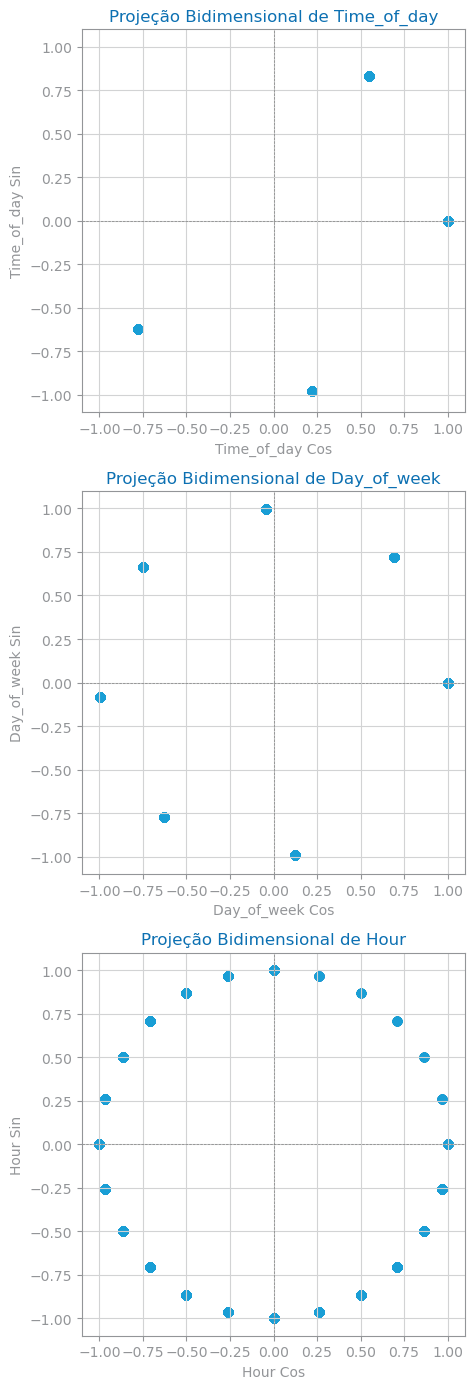

In [31]:
import matplotlib.pyplot as plt

# Lista de variáveis cíclicas
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Criar gráficos de dispersão para cada variável cíclica com tamanho maior
plt.figure(figsize=(14, 14))  # Aumentando o tamanho da figura

for i, var in enumerate(cyclical_vars):
    # Valores de seno e cosseno para a variável atual
    x_values = df_enc[f'{var}_cos']
    y_values = df_enc[f'{var}_sin']
    
    # Criar um subplot para cada variável
    plt.subplot(len(cyclical_vars), 1, i + 1)
    plt.scatter(x_values, y_values, alpha=0.6)
    plt.axhline(0, color='gray', lw=0.5, ls='--')
    plt.axvline(0, color='gray', lw=0.5, ls='--')
    
    # Ajustar os limites dos eixos para melhor visualização
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    # Adicionar título e rótulos
    plt.title(f'Projeção Bidimensional de {var.capitalize()}')
    plt.xlabel(f'{var.capitalize()} Cos')
    plt.ylabel(f'{var.capitalize()} Sin')
    
    # Mostrar a grade
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')  # Para garantir que o gráfico é circular

plt.tight_layout()  # Ajustar o layout
plt.show()  # Mostrar todos os gráficos


In [230]:
df_enc.head()


,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2993783,0,1,2,2,19,0,4.717817,6.9,0.0,0,10.0,2,0.716372,9.110642,0.834,0.551,-0.775,-0.632,0.966,-0.259
2320744,0,1,0,0,3,0,3.831100,5.4,1.6,100,27.5,11,0.597600,9.359196,0.834,0.551,0.663,-0.749,0.707,-0.707
2428859,1,1,0,1,28,1,17.825600,19.0,0.0,1,8.4,3,2.780173,9.357911,0.834,0.551,0.000,1.000,0.259,-0.966
2698272,0,1,0,3,19,0,9.335117,6.9,0.0,0,10.0,2,1.676546,10.775734,0.834,0.551,-0.775,-0.632,0.966,-0.259
816519,0,1,0,0,9,0,18.255000,14.5,0.0,0,7.9,3,3.575442,11.751658,0.834,0.551,0.999,-0.041,0.866,-0.500


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - start_borough
    - end_borough
    - wmo_weather_desc


In [19]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df_enc, columns=["start_borough", "end_borough","wmo_weather_desc"], dtype=int)


display(df_enc.head())

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_4,wmo_weather_desc_0,wmo_weather_desc_1,wmo_weather_desc_2,wmo_weather_desc_3,wmo_weather_desc_6,wmo_weather_desc_7,wmo_weather_desc_8,wmo_weather_desc_11,wmo_weather_desc_12
666377,1,0,10,0,9.106383,10.1,0.0,16,6.3,2.178755,...,0,0,0,0,1,0,0,0,0,0
59948,1,1,29,0,7.536267,26.1,1.8,5,10.5,1.756998,...,0,0,0,0,0,0,0,0,1,0
3009590,1,0,22,0,5.420600,14.8,0.0,0,13.2,1.401950,...,0,1,0,0,0,0,0,0,0,0
326571,1,0,2,0,10.801267,8.2,0.0,90,4.6,1.143191,...,0,0,0,0,1,0,0,0,0,0
2810144,0,0,28,1,12.701883,16.8,0.4,1,4.0,0.930267,...,0,0,0,0,0,1,0,0,0,0


In [202]:
df_enc.shape

(22355, 29)

In [203]:
df_enc.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island'],
      dtype='object')

In [204]:
df_enc.head()

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,...,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island
1956998,1,1,28,1,16.796000,19.5,0.0,0,15.9,3,...,0,1,0,0,0,0,0,1,0,0
1791342,1,0,28,1,21.585283,17.5,0.0,16,5.6,3,...,0,1,0,0,0,1,0,0,0,0
457396,1,1,23,0,6.859900,8.7,0.0,0,12.1,3,...,1,0,0,0,0,1,0,0,0,0
2783650,1,0,14,1,7.588267,19.4,0.0,0,20.3,3,...,0,1,0,0,0,0,0,1,0,0
3148647,1,0,25,0,7.562650,6.0,0.0,0,8.3,3,...,1,0,0,0,0,1,0,0,0,0


# correlation matrix  after enconding

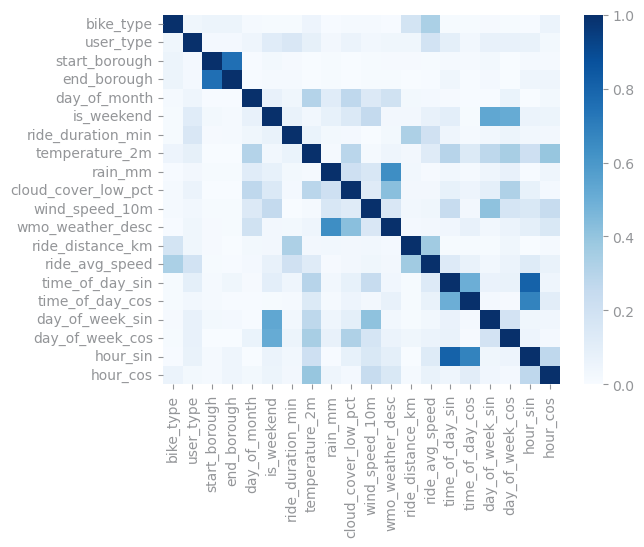

In [32]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show

variables_types: dict[str, list] = get_variable_types(df_enc)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df_enc.corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=df_enc.columns,
    yticklabels=df_enc.columns,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

# Cluster Data Preparation
- To apply clustering thecniques we need to apply specific date preparation thecniques, like scaling, drop of outliers and also feature selection

## Outliers detection

In [33]:
def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(df_enc)
print(variable_types)

{'numeric': ['start_borough', 'end_borough', 'day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': [], 'id': []}


### 1 - Drop Outliers

In [34]:
numeric_vars = variable_types["numeric"]
numeric_vars

['start_borough',
 'end_borough',
 'day_of_month',
 'ride_duration_min',
 'temperature_2m',
 'rain_mm',
 'cloud_cover_low_pct',
 'wind_speed_10m',
 'wmo_weather_desc',
 'ride_distance_km',
 'ride_avg_speed',
 'time_of_day_sin',
 'time_of_day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'hour_sin',
 'hour_cos']

In [35]:
# Usar a função get_variable_types() para obter as variáveis numéricas

variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]

In [57]:
numeric

['day_of_month',
 'hour',
 'ride_duration_min',
 'temperature_2m',
 'rain_mm',
 'cloud_cover_low_pct',
 'wind_speed_10m',
 'ride_distance_km',
 'ride_avg_speed']

- using nr_stdev=2

In [36]:
from pandas import DataFrame, Series


def apply_strategy_2(df: DataFrame, summary5: DataFrame, nr_stdev: float = 2) -> DataFrame:
    df_copy = df.copy()

    # Definindo as variáveis contínuas específicas que desejas monitorar


    # Filtrar apenas as variáveis contínuas que existem no DataFrame
    numeric_vars = [var for var in numeric if var in df_copy.columns]

    if numeric_vars:
        print(f"Data before dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)
        
        # Armazenar informações sobre os outliers
        outlier_info = {}

        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando o número de desvios padrão
            mean = summary5[var]['mean']
            std = summary5[var]['std']
            
            top = mean + nr_stdev * std
            bottom = mean - nr_stdev * std
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            
            # Se houver outliers, armazenar as informações
            if not outliers.empty:
                outlier_info[var] = {
                    'outlier_indices': outliers.index.tolist(),
                    'outlier_count': outliers.shape[0],
                    'outlier_values': outliers[var].tolist()
                }

                # Remover outliers
                df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print(f"Data after dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)

        # Imprimir informações sobre os outliers removidos apenas para as variáveis com outliers
        if outlier_info:
            for var, info in outlier_info.items():
                print(f"Variable '{var}':")
                print(f"  Number of outliers removed: {info['outlier_count']}")
                print(f"  Indices of outliers: {info['outlier_indices']}")
                print(f"  Values of outliers: {info['outlier_values']}")
                print()  # Linha em branco para melhor legibilidade
        else:
            print("No outliers were removed.")
    else:
        print("There are no numeric variables")

    return df_copy

# Usar a função
summary5 = df_enc.describe()  # Calcular o resumo estatístico apenas para as variáveis de interesse
nr_stdev = 2  # Exemplo, mas pode ser alterado para 3 ou outro valor

df_prep_outl_remov = apply_strategy_2(df_enc, summary5, nr_stdev)


Data before dropping outliers with nr_stdev=2: (12774, 20)
Data after dropping outliers with nr_stdev=2: (9101, 20)
Variable 'ride_duration_min':
  Number of outliers removed: 182
  Indices of outliers: [1861247, 635956, 2616440, 2035856, 1954332, 805549, 2296402, 1442348, 1478563, 2100369, 1313219, 2622424, 1479160, 731392, 55270, 2596791, 3143466, 2671674, 386854, 1764484, 1911873, 756530, 951003, 1028182, 114219, 2693868, 1444567, 638225, 2727367, 1087912, 1655077, 1789850, 1524566, 2673504, 3137424, 1033595, 599305, 70604, 501436, 2528946, 2638202, 517883, 1868285, 1119508, 2136578, 1556069, 2260897, 1304629, 2561435, 723547, 585790, 968084, 2385749, 108324, 2586706, 456518, 563033, 2105159, 933529, 2059209, 223321, 2222187, 1224470, 461846, 789762, 3126072, 2252122, 2617481, 2327663, 1147177, 3156401, 587413, 2380315, 1712859, 2137212, 2354623, 2862434, 2531870, 2457219, 1777398, 363565, 902507, 1790885, 2314141, 507900, 2981984, 935685, 1049245, 2879517, 941694, 2091582, 222272, 

In [184]:
display(df_prep_outl_remov.shape)
display(df_prep_outl_remov.columns)

(9409, 20)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [37]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl_remov.shape) # df after enconding and data prep outlier removal


(12774, 17)

(12774, 20)

(9101, 20)

In [61]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
1883354,1,1,0,0,23,0,14.843900,13.0,0.0,0,9.0,0,1.891400,7.645159,0.834,0.551,0.999,-0.041,0.707,-0.707
1829991,1,0,0,0,17,0,10.902617,13.4,0.0,57,18.4,3,3.120631,17.173662,-0.975,0.221,0.663,-0.749,-0.259,-0.966
2049977,0,0,0,0,26,0,69.543383,14.0,0.0,40,13.8,2,0.298281,0.257348,-0.975,0.221,-0.775,-0.632,-0.259,-0.966
2121674,1,1,0,0,7,1,12.492517,14.1,0.0,0,22.4,2,2.350098,11.287229,-0.975,0.221,0.000,1.000,-0.707,-0.707
1261350,1,1,0,0,10,0,29.234000,14.9,0.0,7,16.6,3,2.555404,5.244723,0.834,0.551,0.663,-0.749,0.259,-0.966


#### Check outliers after applying the strategy 1 

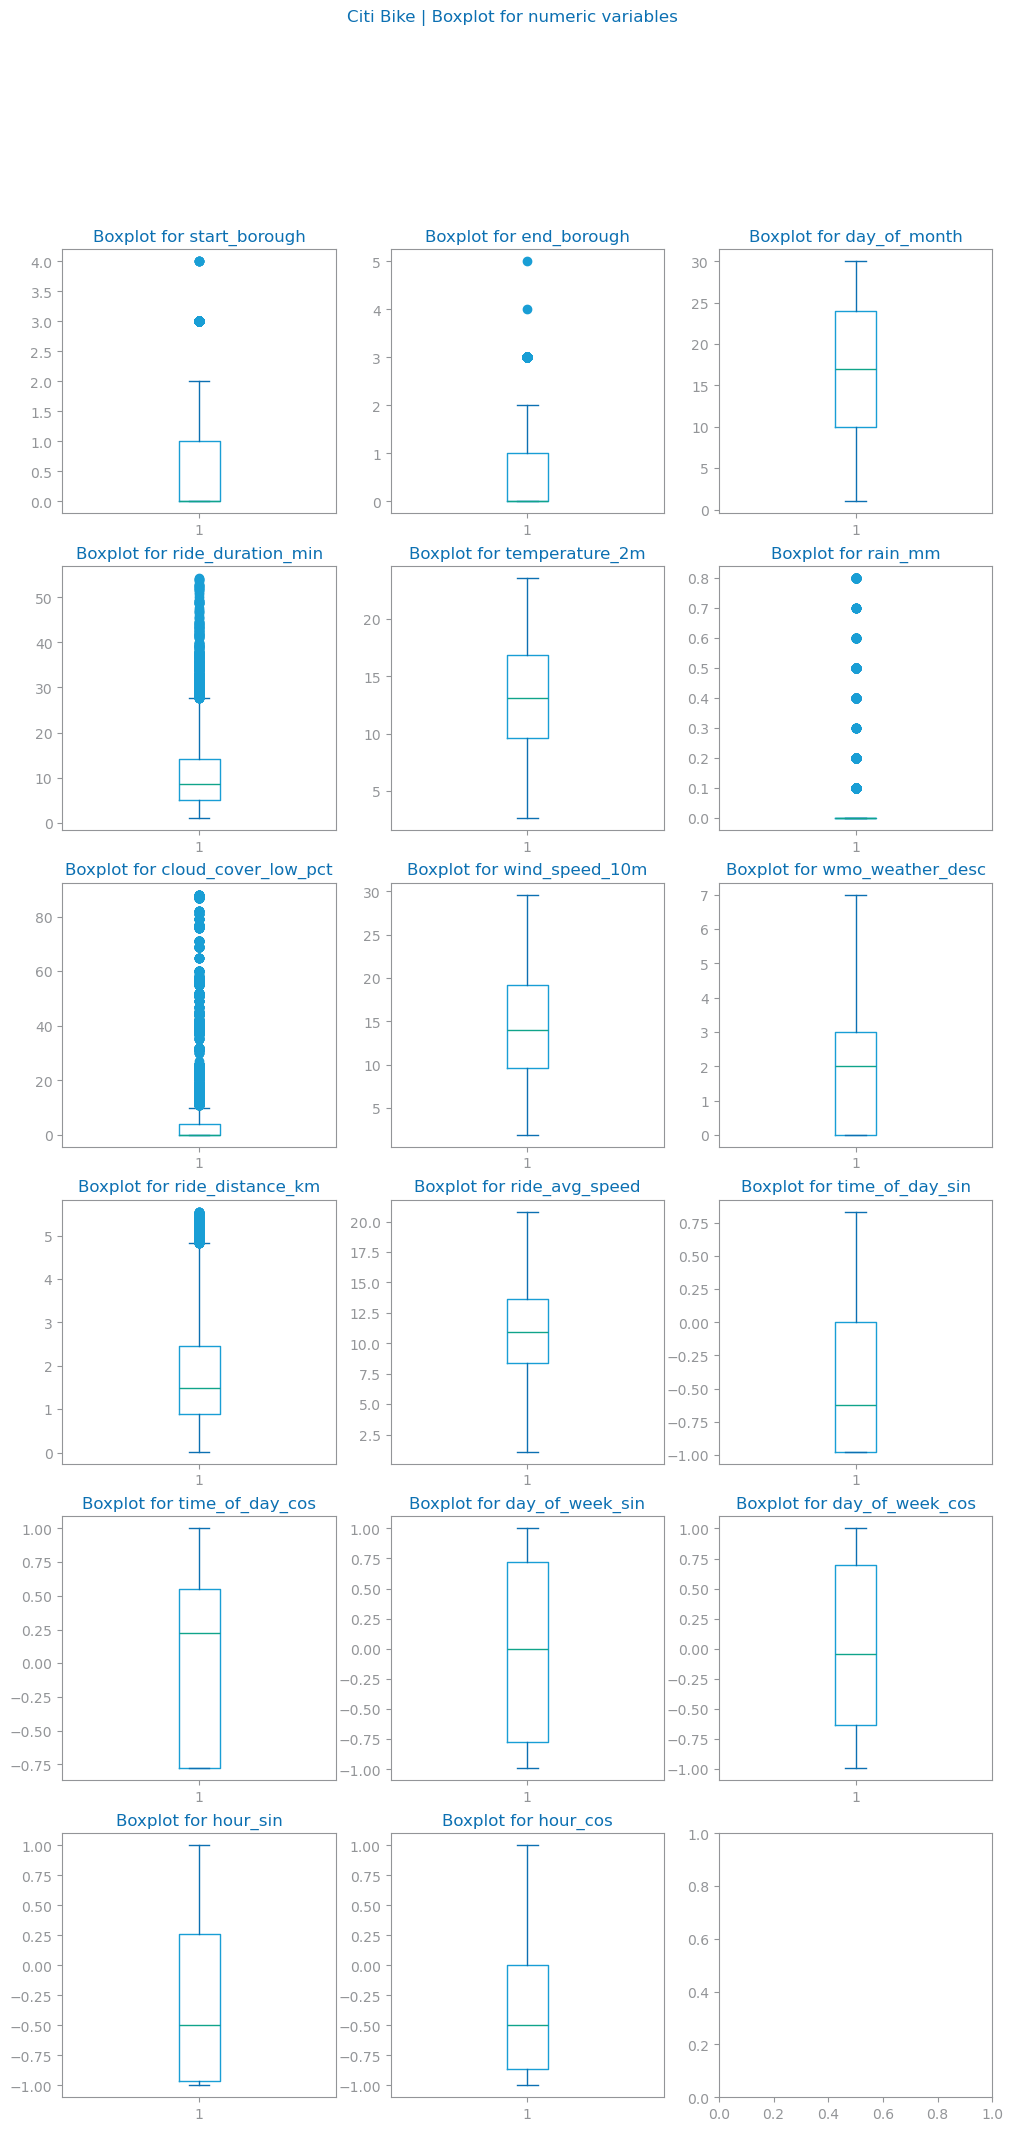

In [38]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_remov[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

#### Removing remaining outliers from vars: ride_distance_km, ride_duration_min, cloud_lower_cover_pct, rain_2_mm

In [107]:
df_prep_outl_remov_final = df_prep_outl_remov[
    (
    (df_prep_outl_remov['ride_duration_min'] <= 21)
    & (df_prep_outl_remov['ride_avg_speed'] < 20)
    & (df_prep_outl_remov['ride_avg_speed'] > 2)
    & (df_prep_outl_remov['ride_distance_km'] < 3.8)
    & (df_prep_outl_remov['rain_mm'] <0.02)
    & (df_prep_outl_remov['cloud_cover_low_pct'] < 1)
    & (df_prep_outl_remov['start_borough'] < 3)
    & (df_prep_outl_remov['end_borough'] < 3)
    )
]
display(df_enc.shape)
display(df_prep_outl_remov.shape)
display(df_prep_outl_remov_final.shape)

display(df_prep_outl_remov_final.head(5))

(25549, 20)

(18440, 20)

(8875, 20)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
695368,1,1,0,0,9,0,4.016733,18.6,0.0,0,15.6,3,0.748161,11.175670,-0.624,-0.781,0.999,-0.041,-0.966,-0.259
1889680,0,1,0,0,12,0,3.265333,13.6,0.0,0,21.1,0,0.526082,9.666678,-0.624,-0.781,-0.775,-0.632,-0.866,0.500
772223,0,1,1,1,6,1,4.655683,9.8,0.0,0,20.0,0,0.521899,6.725963,-0.624,-0.781,-0.993,0.121,-0.966,-0.259
1644860,1,1,0,0,8,0,6.331333,8.8,0.0,0,3.7,1,1.721696,16.315956,0.834,0.551,0.721,0.693,0.866,-0.500
2550776,1,1,0,1,26,0,3.475600,6.5,0.0,0,9.4,0,0.603021,10.410081,0.000,1.000,-0.775,-0.632,-0.707,0.707


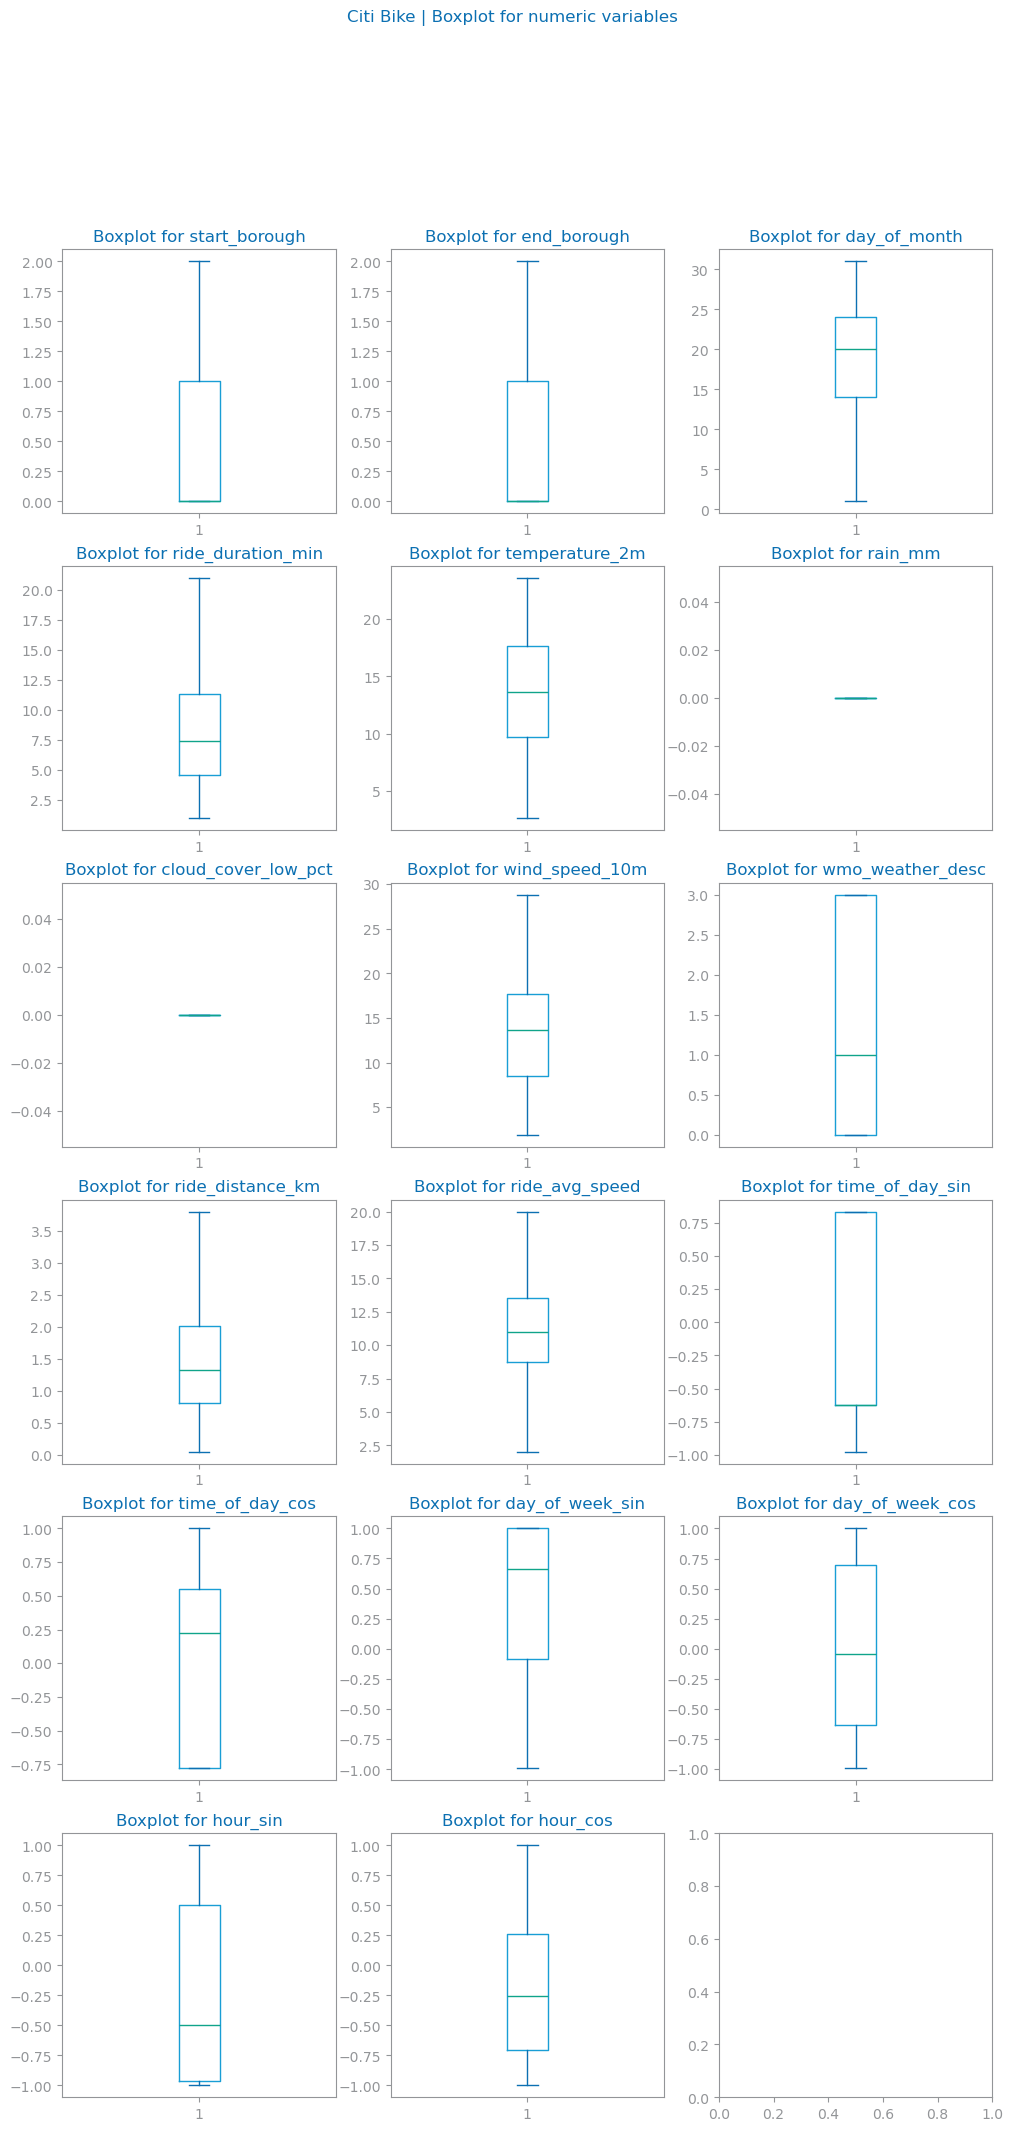

In [108]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_remov_final[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [462]:
display(df_prep_outl_remov['ride_distance_km'].value_counts())
display(df_prep_outl_remov['ride_avg_speed'].value_counts())
display(df_prep_outl_remov['rain_mm'].value_counts())
display(df_prep_outl_remov['cloud_cover_low_pct'].value_counts())



ride_distance_km
0.258034    5
1.026120    4
0.556455    4
0.744055    4
0.534377    3
           ..
3.660739    1
1.238787    1
0.873908    1
1.094363    1
2.229533    1
Name: count, Length: 10251, dtype: int64

ride_avg_speed
10.820796    1
12.421125    1
4.747154     1
7.611351     1
15.643347    1
            ..
9.078553     1
2.982641     1
9.234737     1
7.963124     1
12.227191    1
Name: count, Length: 10514, dtype: int64

rain_mm
0.0    10041
0.2      155
0.4      104
0.1       94
0.5       88
0.3       32
Name: count, dtype: int64

cloud_cover_low_pct
0     6762
1      478
2      477
16     202
4      198
5      183
3      181
17     170
10     148
23     127
8      108
51      96
42      94
7       92
40      89
21      85
25      84
14      73
6       68
44      64
24      63
55      61
32      60
13      58
11      53
31      51
12      48
41      42
58      41
19      40
38      34
57      34
37      33
9       29
47      22
22      19
45      16
56      10
39       9
36       7
59       5
Name: count, dtype: int64

In [109]:
display(df_prep_outl_remov_final['ride_distance_km'].value_counts())
display(df_prep_outl_remov_final['ride_avg_speed'].value_counts())
display(df_prep_outl_remov_final['rain_mm'].value_counts())
display(df_prep_outl_remov_final['cloud_cover_low_pct'].value_counts())

ride_distance_km
0.579884    4
0.260788    4
1.094605    3
0.551986    3
0.562798    3
           ..
1.051770    1
0.808917    1
2.968900    1
2.279569    1
1.843227    1
Name: count, Length: 8657, dtype: int64

ride_avg_speed
11.175670    1
14.773648    1
14.367123    1
8.279083     1
12.772008    1
            ..
15.060983    1
15.532862    1
11.376085    1
12.272704    1
14.896970    1
Name: count, Length: 8875, dtype: int64

rain_mm
0.0    8875
Name: count, dtype: int64

cloud_cover_low_pct
0    8875
Name: count, dtype: int64

In [110]:
display(df_prep_outl_remov_final.shape)

(8875, 20)

### 2 - Truncate Outliers

In [40]:
from pandas import DataFrame
from dslabs_functions import (
    NR_STDEV,
    determine_outlier_thresholds_for_var
)

def apply_strategy_1(df: DataFrame, summary5: DataFrame, numeric_vars: list[str]) -> DataFrame:
    df_copy = df.copy()

    if numeric_vars:
        print("Data before truncating outliers:", df.shape)
        
        for var in numeric_vars:
            # Calculate the outlier thresholds for the variable using summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Truncate outliers for each variable
            df_copy[var] = df_copy[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        
        print("Data after truncating outliers:", df_copy.shape)
    else:
        print("None of the specified continuous variables are in the dataset.")
    
    return df_copy


# Calculate the summary statistics before calling the function
summary5 = df_enc.describe()

# Call the function and pass the continuous variables
df_prep_outl_trunc = apply_strategy_1(df_enc, summary5, numeric_vars)


Data before truncating outliers: (12774, 20)
Data after truncating outliers: (12774, 20)


In [41]:
# Verificar quais colunas foram alteradas e coletar informações
altered_info = {}
# Definindo as variáveis contínuas que desejas monitorar

for var in numeric_vars:
    if var in df_enc.columns and var in df_prep_outl_trunc.columns:  # Verifica se a variável existe em ambos os DataFrames
        altered_indices = df_enc.index[df_enc[var] != df_prep_outl_trunc[var]].tolist()
        if altered_indices:
            altered_count = len(altered_indices)
            new_values = df_prep_outl_trunc.loc[altered_indices, var].to_list()
            altered_info[var] = {'altered_count': altered_count, 'new_values': new_values}

# Imprimir informações das colunas alteradas
for var, info in altered_info.items():
    print(f"Coluna '{var}' foi alterada. Número de linhas alteradas: {info['altered_count']}. Novos valores: {info['new_values']}")


Coluna 'start_borough' foi alterada. Número de linhas alteradas: 1102. Novos valores: [1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.9719931607145011, 1.97199316071

#### Check outliers after Outliers strategy is aplied

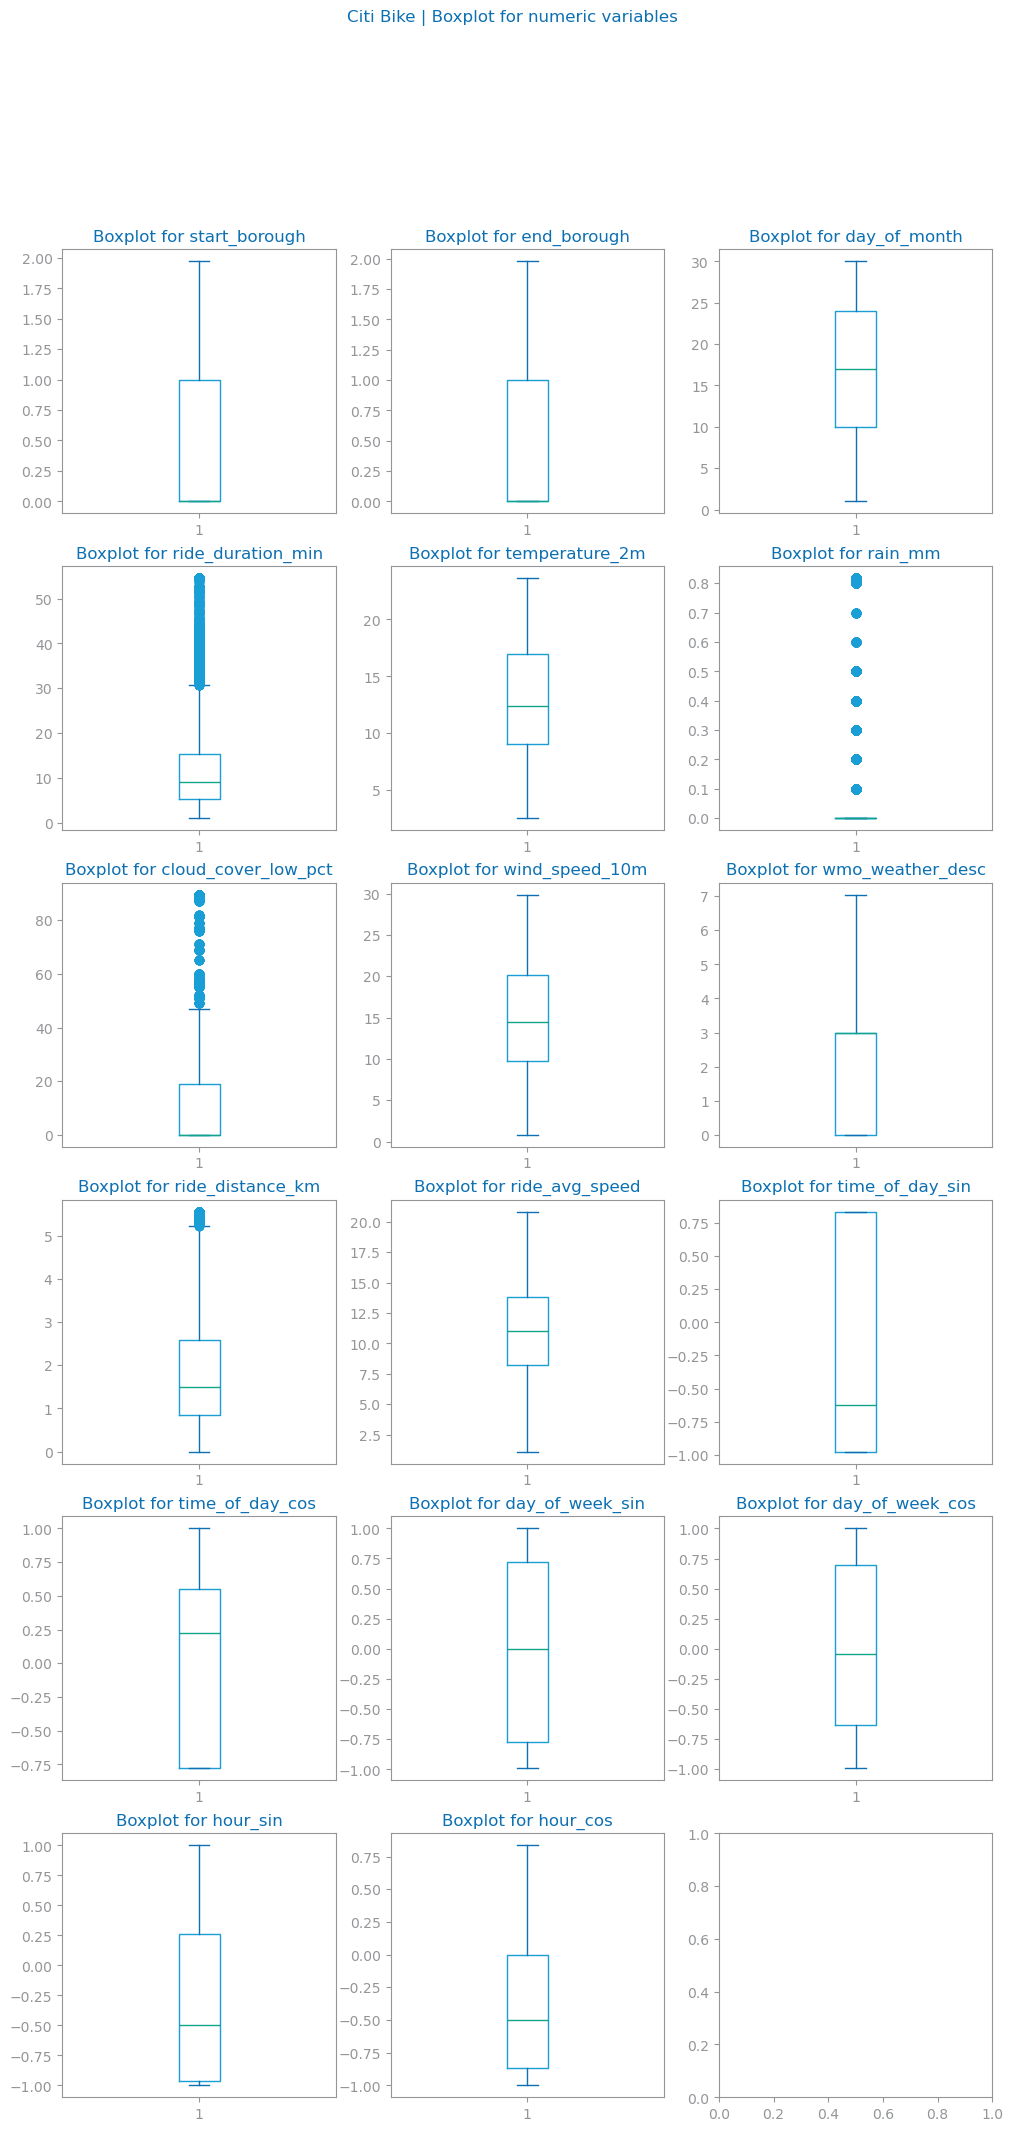

In [42]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_trunc[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [242]:
df_prep_outl_trunc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
2993783,0,1,1.948214,1.955059,19,0,4.717817,6.9,0.00000,0.000000,10.0,2.000000,0.716372,9.110642,0.834,0.551,-0.775,-0.632,0.966,-0.259
2320744,0,1,0.000000,0.000000,3,0,3.831100,5.4,0.77842,90.814081,27.5,6.961571,0.597600,9.359196,0.834,0.551,0.663,-0.749,0.707,-0.707
2428859,1,1,0.000000,1.000000,28,1,17.825600,19.0,0.00000,1.000000,8.4,3.000000,2.780173,9.357911,0.834,0.551,0.000,1.000,0.259,-0.966
2698272,0,1,0.000000,1.955059,19,0,9.335117,6.9,0.00000,0.000000,10.0,2.000000,1.676546,10.775734,0.834,0.551,-0.775,-0.632,0.966,-0.259
816519,0,1,0.000000,0.000000,9,0,18.255000,14.5,0.00000,0.000000,7.9,3.000000,3.575442,11.751658,0.834,0.551,0.999,-0.041,0.866,-0.500


#### Removing remaining outliers from vars: ride_distance_km, ride_duration_min, cloud_lower_cover_pct, rain_2_mm

In [43]:
df_prep_outl_trunc_final = df_prep_outl_trunc[
    (
    (df_prep_outl_trunc['ride_duration_min'] <21)
    & (df_prep_outl_trunc['ride_distance_km'] < 3.7)
    #& (df_prep_outl_trunc['rain_mm'] >0.09)
    #& (df_prep_outl_trunc['cloud_cover_low_pct'] >10)
    & (df_prep_outl_trunc['ride_duration_min'] <= 21)
    & (df_prep_outl_trunc['ride_avg_speed'] < 20)
    & (df_prep_outl_trunc['ride_avg_speed'] > 2)
    & (df_prep_outl_trunc['ride_distance_km'] < 3.8)
    & (df_prep_outl_trunc['rain_mm'] <0.02)
    & (df_prep_outl_trunc['cloud_cover_low_pct'] < 1)
    & (df_prep_outl_trunc['start_borough'] < 3)
    & (df_prep_outl_trunc['end_borough'] < 3)
    )
]

#df_prep_outl_remov_final = df_prep_outl_remov[
#    (
#    (df_prep_outl_remov['ride_duration_min'] <= 23)
#    #& (df_prep_outl_remov['ride_avg_speed'] > 2)
#    #& (df_prep_outl_remov['ride_avg_speed'] > 1)
#    & (df_prep_outl_remov['ride_distance_km'] < 3.7)
#    & (df_prep_outl_remov['rain_mm'] <0.02)
#    & (df_prep_outl_remov['cloud_cover_low_pct'] < 1)
#    & (df_prep_outl_remov['start_borough'] < 3)
#    & (df_prep_outl_remov['end_borough'] < 3)
#    )
#]
display(df_enc.shape)
display(df_prep_outl_remov.shape)

display(df_enc.shape)
display(df_prep_outl_trunc.shape)
display(df_prep_outl_trunc_final.shape)
display(df_prep_outl_trunc.head(5))

(12774, 20)

(9101, 20)

(12774, 20)

(12774, 20)

(4872, 20)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
3100851,1,1,0.000000,0.000000,24,0,5.765967,13.5,0.0,0.000000,10.9,2.0,0.645634,6.718390,0.834,0.551,0.663,-0.749,0.707,-0.707
1861247,1,0,1.971993,1.980202,22,0,54.592825,13.9,0.0,3.000000,12.5,0.0,0.524163,1.106813,-0.975,0.221,0.721,0.693,-0.259,-0.966
2137221,1,1,0.000000,0.000000,10,0,4.337900,15.5,0.0,17.000000,10.8,2.0,0.454597,6.287797,-0.975,0.221,0.663,-0.749,-0.866,-0.500
1728019,1,1,1.000000,0.000000,21,1,11.874033,10.5,0.0,1.000000,19.1,3.0,3.053311,15.428510,-0.975,0.221,0.000,1.000,0.000,-1.000
2847149,1,1,0.000000,0.000000,4,0,11.593283,8.9,0.0,89.412944,14.9,3.0,2.266046,11.727718,-0.975,0.221,-0.081,-0.997,-0.866,-0.500


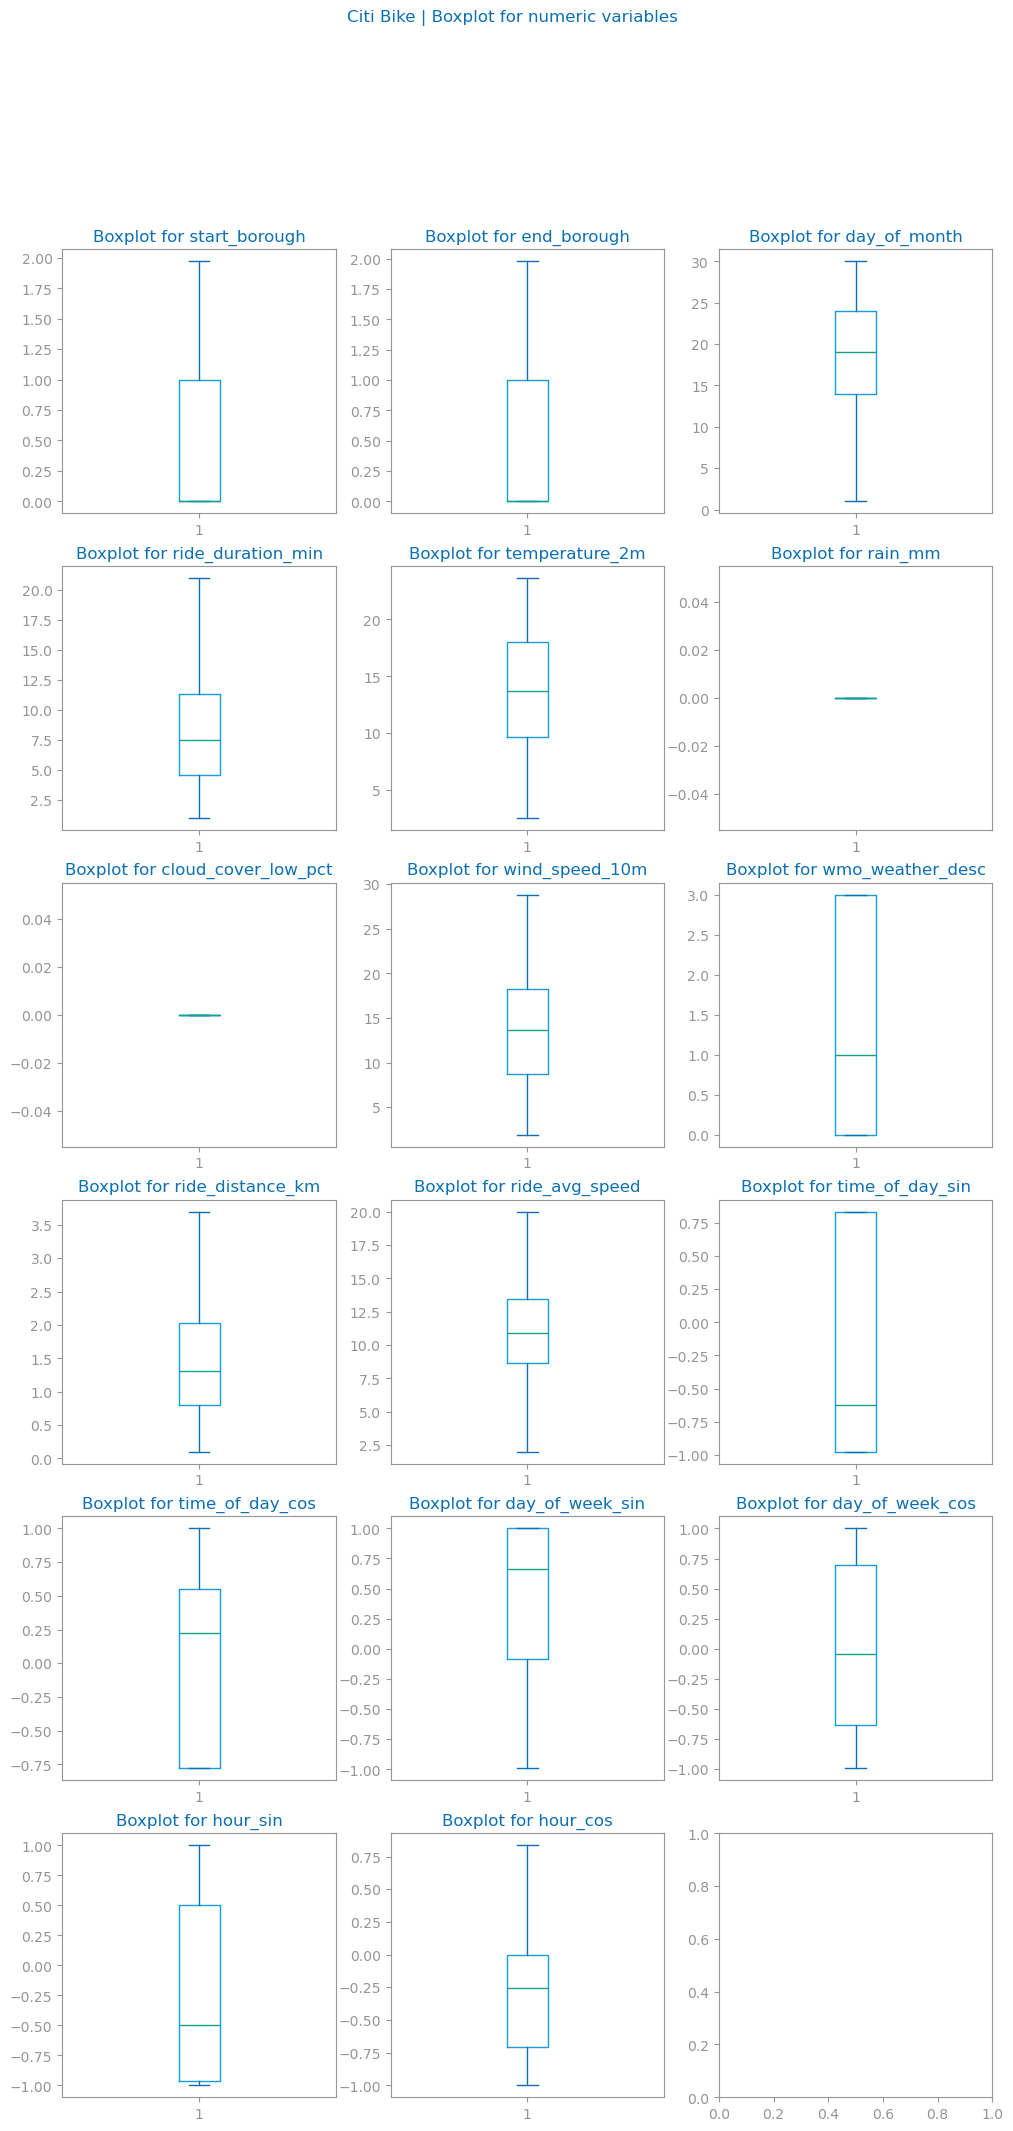

In [44]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(df_prep_outl_trunc_final[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [45]:
df_prep_outl_trunc_final.shape

(4872, 20)

## Scaling

### Scale strategy 1 - Standard Scaler

In [46]:
use_df_in_scaling = "df_prep_outl_trunc_final"  # Pode ser "df_enc" ou "df_prep_outl"

In [48]:
df_prep_outl_trunc_final.shape

(4872, 20)

In [49]:
# Escolher o DataFrame a ser utilizado no scaling com base na variável 'use_df_scaling'
if use_df_in_scaling == "df_enc":
    df_to_use_scal = df_enc
elif use_df_in_scaling == "df_prep_outl_remov":
    df_to_use_scal = df_prep_outl_remov  # Presumo que df_prep_outl seja o outro DataFrame desejado
elif use_df_in_scaling == "df_prep_outl_trunc":
    df_to_use_scal = df_prep_outl_trunc  # Presumo que df_prep_outl seja o outro DataFrame desejado
elif use_df_in_scaling == "df_prep_outl_trunc_final":
    df_to_use_scal = df_prep_outl_trunc_final  # Presumo que df_prep_outl seja o outro DataFrame desejado
elif use_df_in_scaling == "df_prep_outl_remov_final":
    df_to_use_scal = df_prep_outl_remov_final  # Presumo que df_prep_outl seja o outro DataFrame desejado
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_scaling}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the {use_df_in_scaling} dataset, which means that we are {'not ' if use_df_in_scaling == 'df_enc' else ''}considering the removal of outliers.")
print(f"Shape of dataset: {df_to_use_scal.shape}")


We will use the df_prep_outl_trunc_final dataset, which means that we are considering the removal of outliers.
Shape of dataset: (4872, 20)


In [50]:

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def apply_standard_scaler(df: DataFrame) -> DataFrame:

    df_copy = df.copy()
    
    # Apply scaling to all the feature columns (since there is no target)
    transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_copy)
    df_zscore = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_zscore

In [51]:

def apply_strategy_1(df):

    df_copy=df.copy()
    
    df_zscore=apply_standard_scaler(df_copy)

    return df_zscore

df_prep_scal=apply_strategy_1(df_to_use_scal)

df_prep_scal.columns

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [52]:
df_prep_scal.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4872 entries, 3100851 to 2763017
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bike_type            4872 non-null   float64
 1   user_type            4872 non-null   float64
 2   start_borough        4872 non-null   float64
 3   end_borough          4872 non-null   float64
 4   day_of_month         4872 non-null   float64
 5   is_weekend           4872 non-null   float64
 6   ride_duration_min    4872 non-null   float64
 7   temperature_2m       4872 non-null   float64
 8   rain_mm              4872 non-null   float64
 9   cloud_cover_low_pct  4872 non-null   float64
 10  wind_speed_10m       4872 non-null   float64
 11  wmo_weather_desc     4872 non-null   float64
 12  ride_distance_km     4872 non-null   float64
 13  ride_avg_speed       4872 non-null   float64
 14  time_of_day_sin      4872 non-null   float64
 15  time_of_day_cos      4872 non-null

In [53]:
df_prep_scal.shape

(4872, 20)

In [55]:
display(df_prep_scal['bike_type'].value_counts())
display(df_prep_scal['user_type'].value_counts())
display(df_prep_scal['is_weekend'].value_counts())

bike_type
 0.759407    3090
-1.316817    1782
Name: count, dtype: int64

user_type
 0.443574    4071
-2.254417     801
Name: count, dtype: int64

is_weekend
-0.577666    3653
 1.731103    1219
Name: count, dtype: int64

### Scale strategy 2 - MinMax Scaler


In [56]:
from sklearn.preprocessing import MinMaxScaler

def apply_min_max_scaler(df: DataFrame) -> DataFrame:

    df_copy=df.copy()
        # Apply MinMax scaling to the feature columns only
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_copy)
    df_minmax = DataFrame(transf.transform(df_copy), index=df_copy.index, columns=df_copy.columns)
    
    return df_minmax

In [58]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler


def apply_strategy_2(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Scaling chapter
    df_copy=apply_min_max_scaler(df)

    return df_copy

df_pre_scal_2=apply_strategy_2(df_to_use_scal)
df_pre_scal_2.columns

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [59]:
df_pre_scal_2.shape

(4872, 20)

#### scaling plot - visualize oth streategies

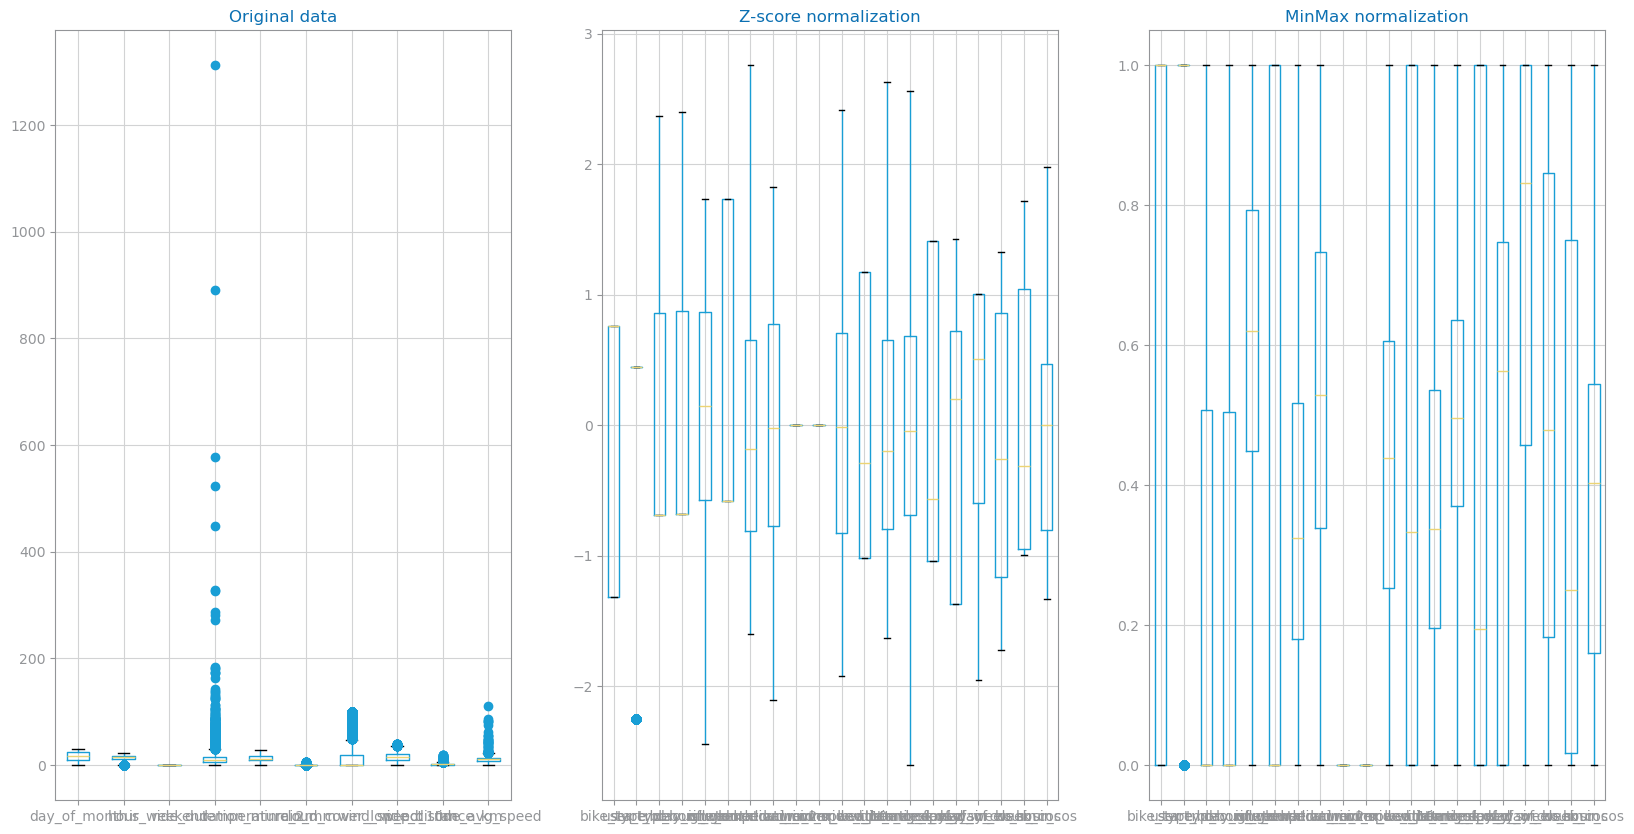

In [60]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 0].set_title("Original data")
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title("Z-score normalization")
df_prep_scal.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_pre_scal_2.boxplot(ax=axs[0, 2])
show()

### Analysis insights

- Let's proceed with the dataste df_prep_scal, where we applied standard scaling

## Feature selection

### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [61]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_feat_eng' (feature engineering)
if use_df_in_feat_eng == "df_enc":
    df_to_use_feat = df_enc
elif use_df_in_feat_eng == "df_prep_outl":
    df_to_use_feat = df_prep_outl_trunc_final
elif use_df_in_feat_eng == "df_prep_scal":
    df_to_use_feat = df_prep_scal
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_feat_eng}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_feat_eng} dataset, which means that we are {'not ' if use_df_in_feat_eng == 'df_enc' else ''}considering the removal of outliers and also scaled data")
print(f"Shape of dataset: {df_to_use_feat.shape}")


We will use the dataset df_prep_scal dataset, which means that we are considering the removal of outliers and also scaled data
Shape of dataset: (4872, 20)


In [62]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
selected_features = df_to_use_feat.columns[selector.get_support()]
print(selected_features)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos'],
      dtype='object')


In [63]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", df_to_use_feat.columns.tolist())

# Compute variance for each feature
feature_variance = df_to_use_feat.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
initial_features = list(set(df_to_use_feat.columns))
removed_features = list(set(df_to_use_feat.columns) - set(selected_features))
selected_features = df_to_use_feat.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['bike_type', 'user_type', 'start_borough', 'end_borough', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos']

Feature Variance:
 bike_type              1.000205
user_type              1.000205
start_borough          1.000205
end_borough            1.000205
day_of_month           1.000205
is_weekend             1.000205
ride_duration_min      1.000205
temperature_2m         1.000205
rain_mm                0.000000
cloud_cover_low_pct    0.000000
wind_speed_10m         1.000205
wmo_weather_desc       1.000205
ride_distance_km       1.000205
ride_avg_speed         1.000205
time_of_day_sin        1.000205
time_of_day_cos        1.000205
day_of_week_sin        1.000205
day_of_week_cos        1.000205
hour_sin               1.000205
hour_cos       

In [64]:
df_prep_feat_var = df_to_use_feat[selected_features]

In [65]:
df_prep_feat_var.shape

(4872, 18)

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

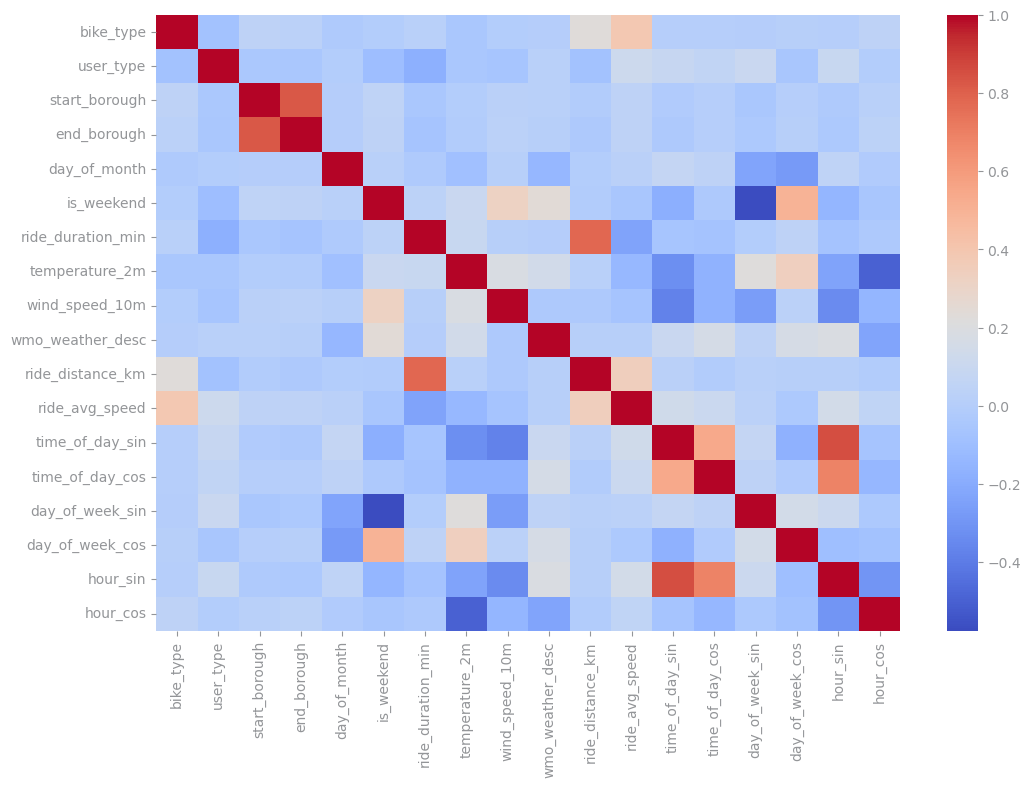

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [67]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] >=0.7:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.7):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_feat = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_feat.columns)}")
print(f"Remaining features: {df_prep_feat.columns.tolist()}")


Initial number of features: 18
Redundant pairs (correlation > 0.7):
start_borough and end_borough: Correlation = 0.8276539801048103
ride_duration_min and ride_distance_km: Correlation = 0.782909855609938
time_of_day_sin and hour_sin: Correlation = 0.8565132361693998
Number of features dropped: 3
Features dropped: ['end_borough', 'ride_distance_km', 'hour_sin']
Remaining features: 15
Remaining features: ['bike_type', 'user_type', 'start_borough', 'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m', 'wind_speed_10m', 'wmo_weather_desc', 'ride_avg_speed', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_cos']


In [68]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl_trunc_final.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_feat.shape) 

(12774, 17)

(12774, 20)

(4872, 20)

(4872, 18)

(4872, 15)

# Cluster Application Techinques 

In [69]:

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_clust' (clustering)
if use_df_in_clust == "df_enc":
    df_to_use_clust = df_enc
elif use_df_in_clust == "df_prep_outl":
    df_to_use_clust = df_prep_outl_trunc_final
elif use_df_in_clust == "df_prep_scal":
    df_to_use_clust = df_prep_scal
elif use_df_in_clust == "df_prep_feat":
    df_to_use_clust = df_prep_feat
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_clust}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_clust} dataset, which means that we are {'not ' if use_df_in_clust == 'df_enc' else ''}considering the removal of outliers and also scaled data, and also removal of non relevant features")
print(f"Shape of dataset: {df_to_use_clust.shape}")

We will use the dataset df_prep_feat dataset, which means that we are considering the removal of outliers and also scaled data, and also removal of non relevant features
Shape of dataset: (4872, 15)


In [70]:
df_to_use_clust.head()

,bike_type,user_type,start_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,wind_speed_10m,wmo_weather_desc,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_cos
3100851,0.759407,0.443574,-0.689938,0.865807,-0.577666,-0.561673,-0.062658,-0.468014,0.441954,-1.254140,1.413639,0.719827,0.507545,-1.346055,-0.804735
1053424,-1.316817,0.443574,2.373096,-0.142370,-0.577666,-0.844206,-0.286448,-0.081136,1.173837,-0.771306,1.413639,0.719827,0.507545,-1.346055,-0.431136
1664122,0.759407,0.443574,-0.689938,-0.430420,-0.577666,-0.168107,1.825388,1.063380,0.441954,0.304595,-1.044813,0.202565,0.593804,0.859815,-1.272185
975011,0.759407,0.443574,2.373096,0.433731,1.731103,-0.986609,-1.610536,-0.129496,-1.021812,1.301610,0.280223,1.423616,-0.478486,1.329442,1.980226
2674506,0.759407,0.443574,2.373096,-0.430420,-0.577666,0.696742,0.776552,-0.645334,-1.021812,-0.956261,-0.567800,-1.368029,0.593804,0.859815,0.938726


In [71]:
df_to_use_clust.columns

Index(['bike_type', 'user_type', 'start_borough', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'wind_speed_10m',
       'wmo_weather_desc', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_cos'],
      dtype='object')

## K means Clustering

In [403]:
#df_to_use_clust = df_to_use_clust.sample(frac=0.5, random_state=42)


### Elbow method study

#### Elbow method - definition

The Elbow Method is a heuristic technique used to determine the optimal number of clusters (k) in K-Means clustering. It works by plotting the Sum of Squared Distances (SSD), also called inertia, for different values of k.

The SSD represents how tightly the data points are grouped within their respective clusters (coesão dos clusters) —the lower the SSD, the better the clustering. However, increasing k will always decrease the SSD, so the goal is to find a balance:

- Too few clusters → High SSD, underfitting the data.
- Too many clusters → Very low SSD, but overfitting, leading to unnecessary complexity.
The elbow point is where adding more clusters does not significantly reduce SSD. This is visually identified as the point where the curve bends like an elbow.

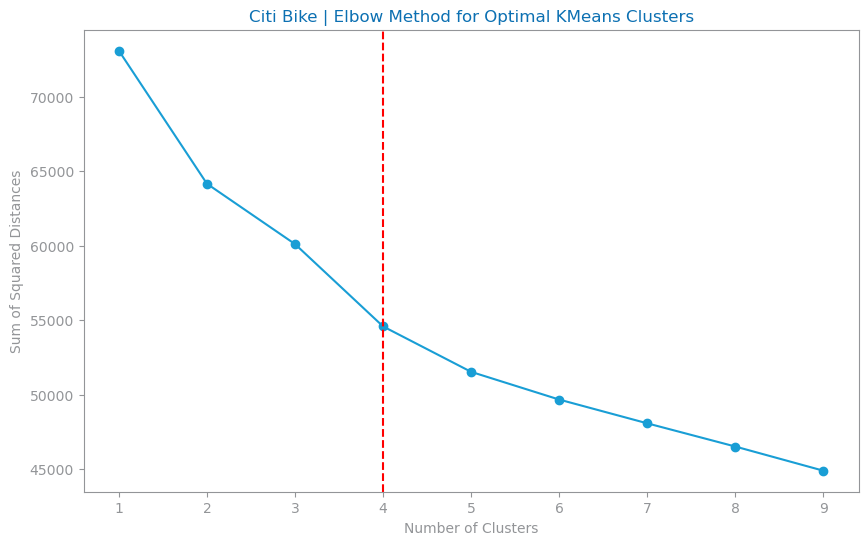

In [72]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 10))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_to_use_clust)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

## Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()


#### How to interpret the elbow point

Interpretation:

- High SSD → Observations within the same cluster are more dispersed. The clusters are less cohesive.
- Low SSD → Observations are closer to each other within the cluster, indicating high cohesion.
- In the Elbow Method, we look for the point where the gain in cohesion starts to decrease as the number of clusters increases, indicating that adding more clusters does not significantly improve data compactness.

#### Analysis of Elbow Method for Optimal KMeans Clusters

- The x-axis represents the number of clusters (k).
- The y-axis represents the Sum of Squared Distances (SSD).
- The red dashed line marks k = 4, which is likely the optimal number of clusters.

Why k=4?

- The SSD decreases rapidly between k=1 and k=4, indicating that adding clusters significantly improves compactness.
- After k=4, the rate of SSD reduction slows down, meaning additional clusters provide diminishing returns.
- The elbow shape is visible at k=4, supporting this choice as the best trade-off between variance explained and simplicity.

In [73]:
print(f"Elbow Point: {elbow_point}")


Elbow Point: 4


### Sillhouete study for kmeans

#### Sillhouete study for kmeans - Definition

- The Silhouette Score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1:

    - Close to 1 → The sample is well clustered.
    - Around 0 → The sample is on the decision boundary between two clusters.
    - Close to -1 → The sample is likely in the wrong cluster.

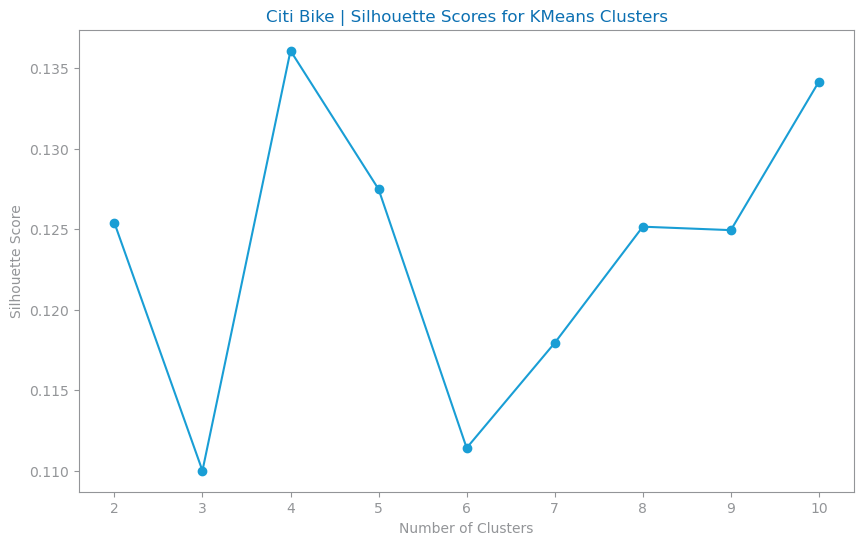

In [74]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_to_use_clust)
    silhouette_avg = silhouette_score(df_to_use_clust, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

#### How to interpret the Silhuete score

Interpreting the Silhouette Score from the Graph
Looking at the Silhouette Scores for different numbers of clusters:

- The highest score is for k = 5, suggesting it provides the best clustering separation.
    - k = 9 also has a relatively high score.
    - k = 3, 7, and 8 have the lowest scores, indicating poor clustering structure.
- The best choice for k should be the one with the highest silhouette score, which in this case is k = 5.

### Kmeans model

In [75]:
df_to_use_clust.shape

(4872, 15)

In [76]:
# Clustering
citibike_kmeans = KMeans(n_clusters=4, random_state=42)
citibike_y_pred_kmeans = citibike_kmeans.fit_predict(df_to_use_clust)

citibike_kmeans.cluster_centers_

array([[-0.00418901, -0.00882505, -0.02023993, -0.02037879, -0.57766628,
         0.03392513,  0.25883826,  0.05787632, -0.27991843, -0.09027358,
        -0.76087668, -0.73231243,  0.34281729, -0.22185096,  0.03041174],
       [-0.00402633,  0.19607029, -0.06772742,  0.07405026, -0.43938516,
        -0.08143679, -0.21378919, -0.49911756,  0.19003972,  0.19179752,
         1.41363913,  0.7198268 ,  0.27038176, -0.29033512, -0.57600528],
       [ 0.10057096, -0.00532023,  0.06482631,  0.04612295, -0.00740415,
        -0.16089761, -1.10035526, -0.38744222, -0.28114137,  0.1987643 ,
         0.32688199,  1.39464364, -0.10136548, -0.08593038,  1.75429523],
       [-0.04523397, -0.23905057,  0.09185978, -0.08467292,  1.7311033 ,
         0.13478939,  0.41420515,  0.77305926,  0.4676727 , -0.19142617,
        -0.55541329, -0.31821693, -0.97817148,  0.87448116, -0.32433326]])

## Hierarchical Clustering - Agglomerative

### Sillouette Study for Agglomerative

In [77]:
from sklearn.cluster import AgglomerativeClustering

def evaluate_agglomerative_clustering(X, 
                                      n_clusters_list=[2, 3, 4, 5], 
                                      metric_list=['euclidean', 'manhattan', 'cosine', 'chebyshev', 'hamming'], 
                                      linkage_list=['ward', 'complete', 'average', 'single'],
                                      scale='no',
                                      title='Silhouette Scores for Different Clustering Parameters'):
    # Scale the data if required
    if scale == 'yes':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Store the results
    results = []

    for n_clusters in n_clusters_list:
        for metric in metric_list:
            for linkage in linkage_list:
                if linkage == 'ward' and metric != 'euclidean':
                    continue  # Ward linkage only works with Euclidean distance
                clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
                labels = clustering.fit_predict(X)
                score = silhouette_score(X, labels)
                results.append((n_clusters, metric, linkage, score))

    # Convert results to a structured array for easy plotting
    dtype = [('n_clusters', int), ('metric', 'U10'), ('linkage', 'U10'), ('score', float)]
    results = np.array(results, dtype=dtype)

    # Plot the results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    
    for ax, linkage in zip(axes, linkage_list):
        for metric in metric_list:
            subset = results[(results['metric'] == metric) & (results['linkage'] == linkage)]
            ax.plot(subset['n_clusters'], subset['score'], label=f'{metric}')
            for (n_clusters, score) in zip(subset['n_clusters'], subset['score']):
                ax.text(n_clusters, score, f'{score:.2f}', fontsize=8, ha='right')
        
        ax.set_title(f'Linkage: {linkage}')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.legend(loc='upper right')
        ax.set_xticks(n_clusters_list)
        ax.set_xticklabels([str(n) for n in n_clusters_list])
    
    fig.suptitle(title, fontsize=16)
    plt.show()



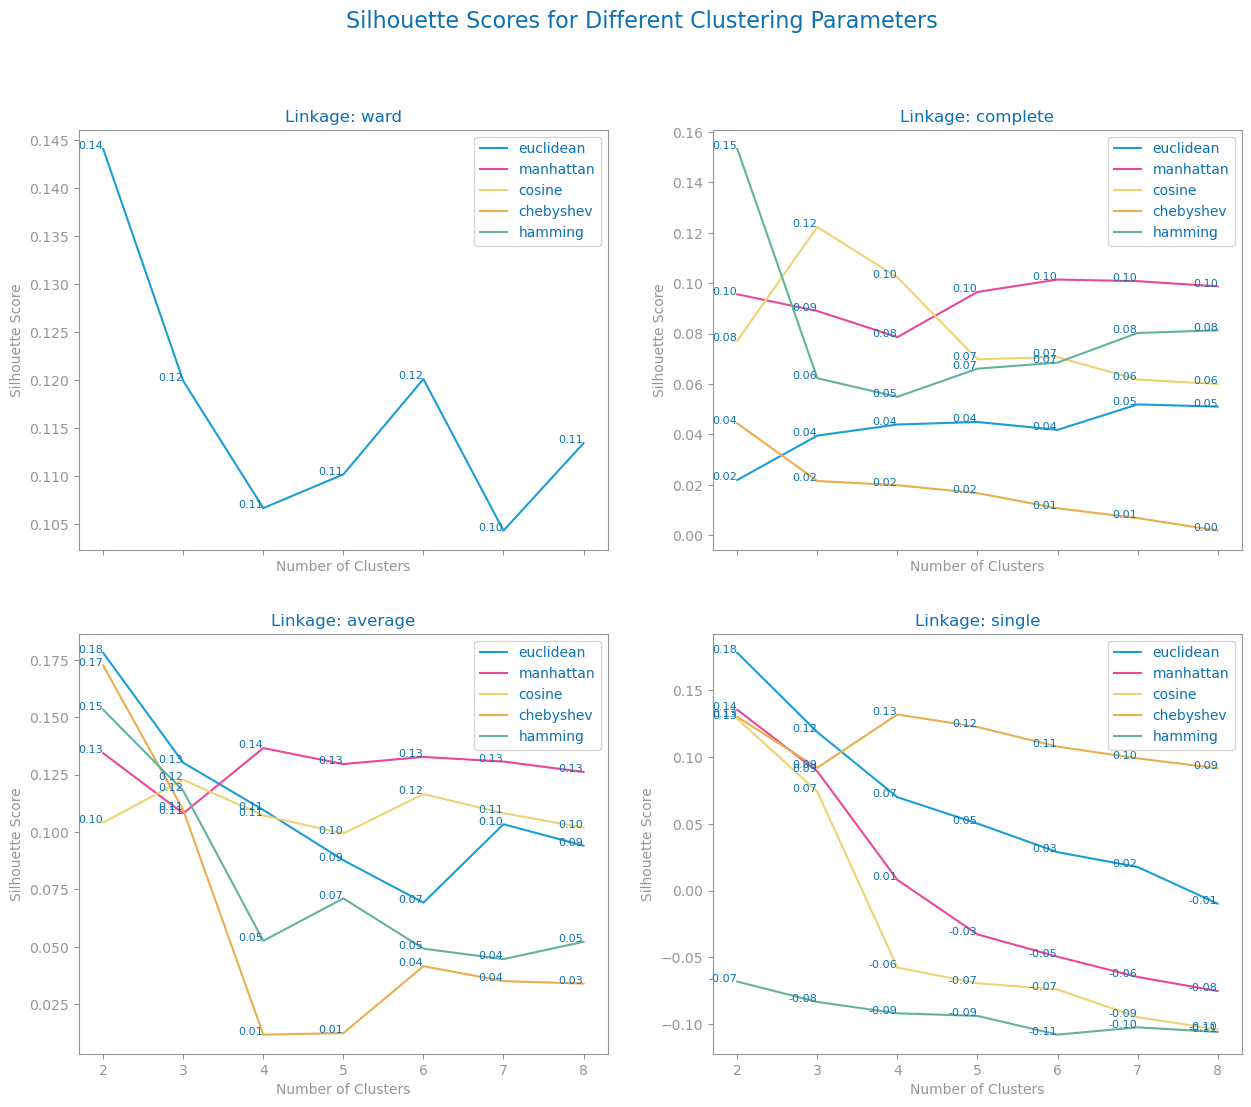

In [78]:
evaluate_agglomerative_clustering(df_to_use_clust, n_clusters_list=[2, 3, 4, 5,6,7,8], scale='no')

### Dendrogram

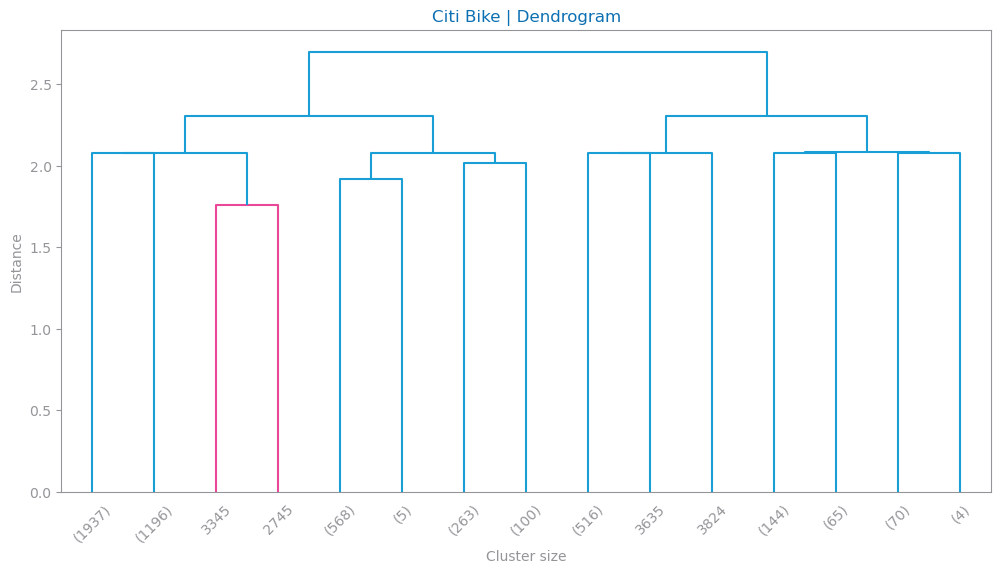

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(df_to_use_clust, method='single', metric='chebyshev')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


In [80]:
df_to_use_clust.shape


(4872, 15)

### Agglomerative Model

In [82]:
from sklearn.cluster import AgglomerativeClustering

citibike_agglo = AgglomerativeClustering(n_clusters=4, metric='chebyshev', linkage='single' )
citibike_y_pred_agglo = citibike_agglo.fit_predict(df_to_use_clust)

citibike_y_pred_agglo

array([3, 3, 3, ..., 3, 3, 1])

In [83]:
display(citibike_y_pred_agglo.shape)
display(citibike_y_pred_kmeans.shape)


(4872,)

(4872,)

# Clustering approaches Evaluation

In [84]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(df_to_use_clust, citibike_y_pred_kmeans)
silhouette_agglo = silhouette_score(df_to_use_clust, citibike_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')


Silhouette Score for KMeans: 0.13609579830270888
Silhouette Score for Agglomerative Clustering: 0.13189178783904193


# Clustering visualization

## Cluster Labeling

In [85]:
df_prep_outl_trunc_final.shape

(4872, 20)

In [86]:
df_to_use_clust_labeled = df_prep_outl_trunc_final.copy()

In [87]:
# Add cluster labels to the dataframe
df_to_use_clust_labeled['kmeans_cluster'] = citibike_y_pred_kmeans
df_to_use_clust_labeled['agglo_cluster'] = citibike_y_pred_agglo

# Display the dataframe with the new cluster labels
df_to_use_clust_labeled.head(20)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,...,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,kmeans_cluster,agglo_cluster
3100851,1,1,0.000000,0.000000,24,0,5.765967,13.500000,0.0,0.0,...,0.645634,6.718390,0.834,0.551,0.663,-0.749,0.707,-0.707000,1,3
1053424,0,1,1.971993,1.980202,17,0,4.469933,12.300000,0.0,0.0,...,0.625762,8.399618,0.834,0.551,0.663,-0.749,0.866,-0.500000,1,3
1664122,1,1,0.000000,0.000000,15,0,7.571333,23.624046,0.0,0.0,...,1.532678,12.145906,-0.975,0.221,0.721,0.693,-0.259,-0.966000,0,3
975011,1,1,1.971993,1.980202,21,1,3.816700,5.200000,0.0,0.0,...,0.993456,15.617512,0.000,1.000,0.000,1.000,-0.259,0.836064,2,1
2674506,1,1,1.971993,0.000000,15,0,11.538567,18.000000,0.0,0.0,...,1.491476,7.755606,-0.624,-0.781,0.721,0.693,-0.966,0.259000,0,3
1788568,0,1,0.000000,0.000000,14,1,7.260167,17.700000,0.0,0.0,...,0.781008,6.454463,0.834,0.551,0.000,1.000,0.259,-0.966000,3,1
1155706,1,1,0.000000,0.000000,27,1,4.597133,7.000000,0.0,0.0,...,1.493609,19.494005,0.834,0.551,-0.993,0.121,0.966,-0.259000,1,1
2814824,0,1,1.000000,1.000000,26,0,1.781967,3.300000,0.0,0.0,...,0.275631,9.280682,0.000,1.000,-0.775,-0.632,0.000,0.836064,2,3
2834306,0,1,1.000000,1.000000,25,0,19.044583,5.600000,0.0,0.0,...,3.259470,10.268967,0.000,1.000,-0.081,-0.997,-0.259,0.836064,2,3
1914474,1,1,0.000000,0.000000,23,0,6.320833,14.600000,0.0,0.0,...,1.277256,12.124246,-0.975,0.221,0.999,-0.041,0.000,-1.000000,0,3


In [155]:
display(df_to_use_clust.shape)
display(df_to_use_clust_labeled.shape)

(8875, 15)

(8875, 22)

##  Cluster Counts

In [88]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = df_to_use_clust_labeled.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = df_to_use_clust_labeled.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0    1974
1    1319
2     583
3     996
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0     283
1     936
2     518
3    3135
dtype: int64


## Cluster description boxplots

In [89]:

import seaborn as sns

def plot_cluster_boxplots(dataframe, features, cluster_labels):
    """
    Plots boxplots for the given features in the dataframe, comparing the specified cluster labels.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    features (list): List of features to plot.
    cluster_labels (list): List of cluster labels to compare.
    """
    # Create subplots
    fig, axes = plt.subplots(nrows=len(features), ncols=len(cluster_labels), figsize=(15, 5 * len(features)))

    # Loop through each feature and create boxplots
    for i, feature in enumerate(features):
        for j, cluster_label in enumerate(cluster_labels):
            sns.boxplot(x=cluster_label, y=feature, data=dataframe, ax=axes[i, j])
            axes[i, j].set_title(f'{cluster_label} - {feature}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [90]:
# Get selected features
selected_features_clust = df_to_use_clust.columns
print(selected_features_clust)

Index(['bike_type', 'user_type', 'start_borough', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'wind_speed_10m',
       'wmo_weather_desc', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_cos'],
      dtype='object')


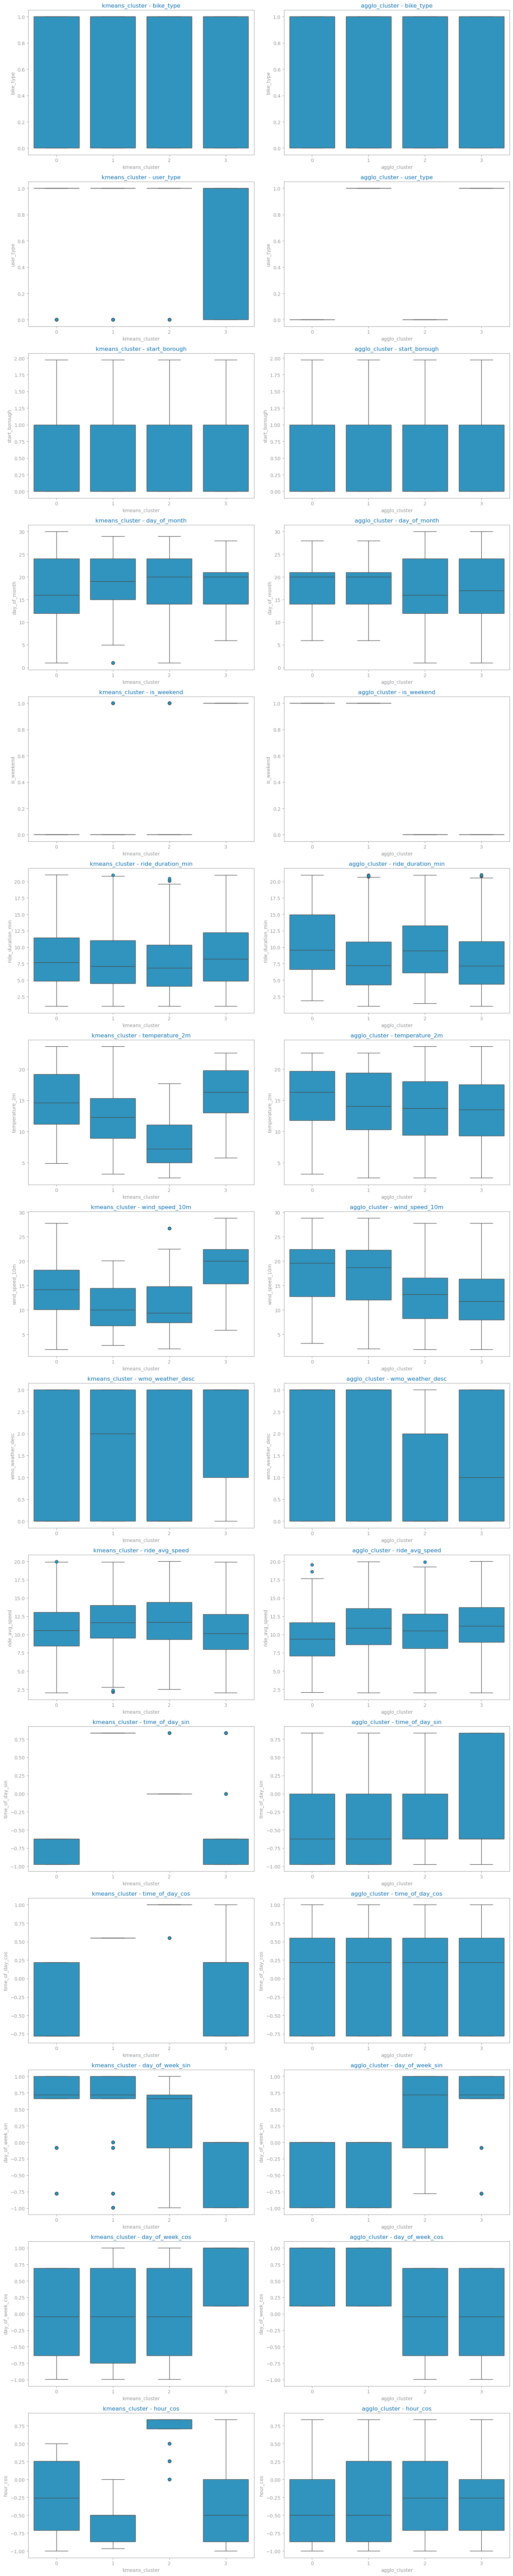

In [91]:

features = selected_features_clust

cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(df_to_use_clust_labeled, features, cluster_labels)

## Cluster Centroids -  Heatmap For Feature Importance)
Another way to analyze clustering is by visualizing the centroid values for each feature.

Heatmap of Cluster Centroids: Helps interpret which features are important for each cluster.



In [335]:
print(len(df_to_use_clust.columns))  # Deve ser 22 para bater certo com os centroids


17


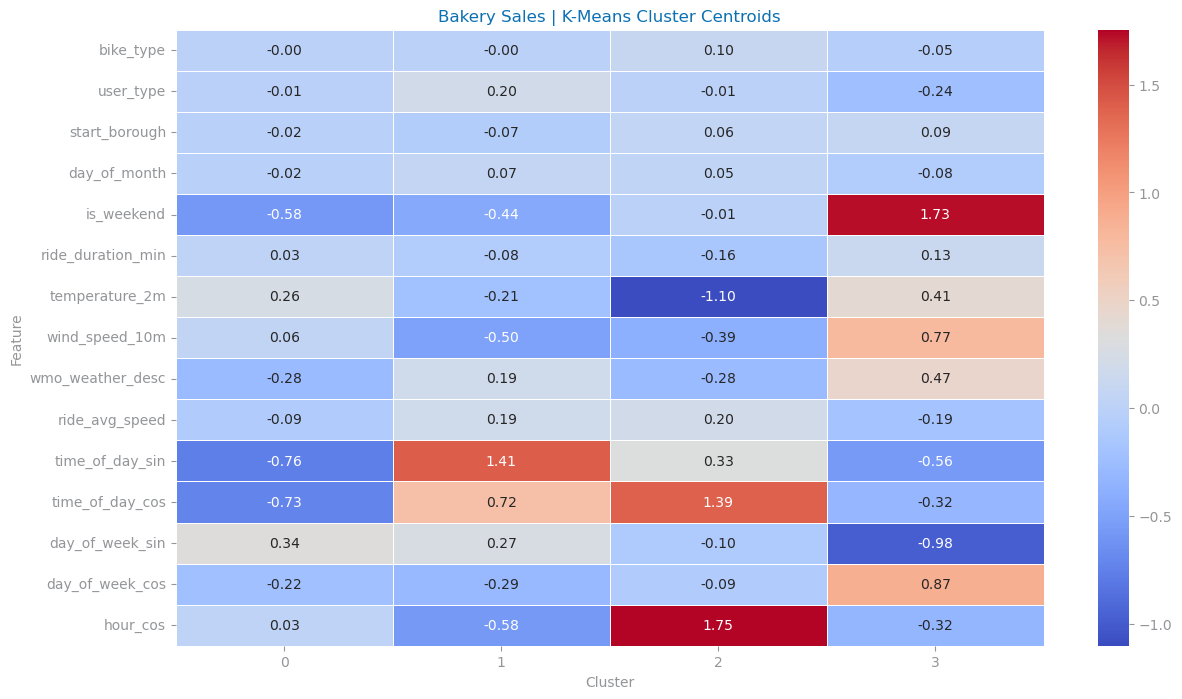

In [92]:
import seaborn as sns
import pandas as pd

# Create a dataframe of centroids
centroids = pd.DataFrame(citibike_kmeans.cluster_centers_, columns=df_to_use_clust.columns)

# Plot a heatmap of feature values for each cluster
plt.figure(figsize=(14, 8))
sns.heatmap(centroids.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Bakery Sales | K-Means Cluster Centroids")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()


## PCA

### PCA visualization

In [93]:
from sklearn.decomposition import PCA

#df.drop(columns=['kmeans_cluster', 'agglo_cluster'], inplace=True)
df_to_use_clust
# Visualization
pca_reorder = PCA(n_components=7)
numeric_features_pca = pca_reorder.fit_transform(df_to_use_clust)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-1.608137,-0.712078,0.303079,1.371839,-0.938588,0.448578,-0.476048
1,-1.378448,-0.846616,0.614055,1.395685,-0.533828,-0.840407,2.778954
2,1.568267,-1.752968,-0.332080,-0.830988,-1.504431,0.281167,-0.780411
3,-0.940229,1.690624,2.321925,-2.011494,1.284492,-0.973527,1.759256
4,0.615714,-0.010297,-1.827191,-1.138243,0.785536,0.212497,2.157235


In [178]:
df_to_use_clust.shape

(8875, 15)

### PCA explained variance ratio

In [94]:
# Fit the PCA model


pca_reorder.fit(df_to_use_clust)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
total_variance_explained = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total variance explained: {total_variance_explained:.4f}')


Explained variance ratio: [0.16019546 0.12189389 0.11005454 0.09458625 0.08281821 0.07720018
 0.06612823]
Total variance explained: 0.7129


### PCA plot

#### 2D PCA Plot

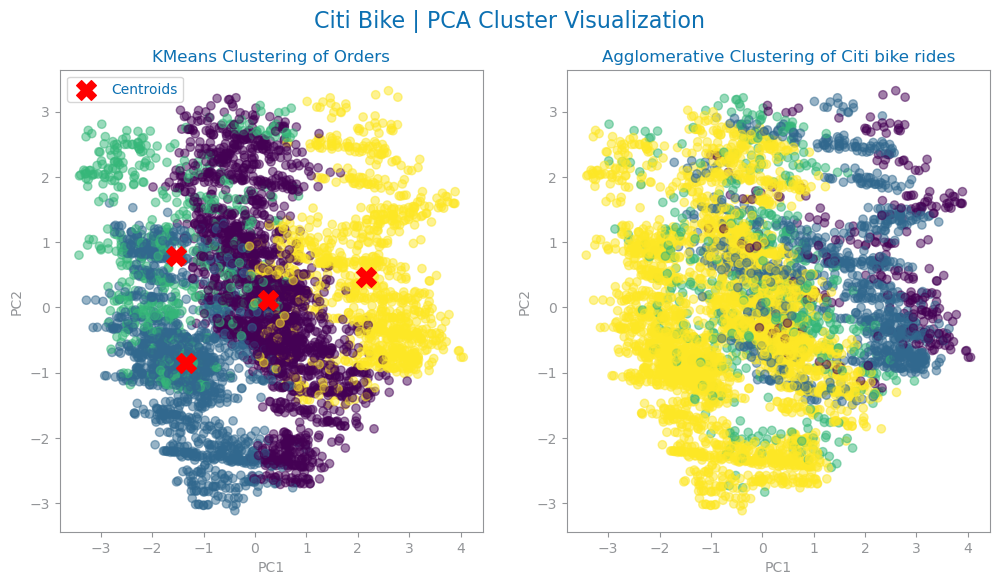

In [95]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(citibike_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Citi bike rides')

plt.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

#### 3D PCA Plot

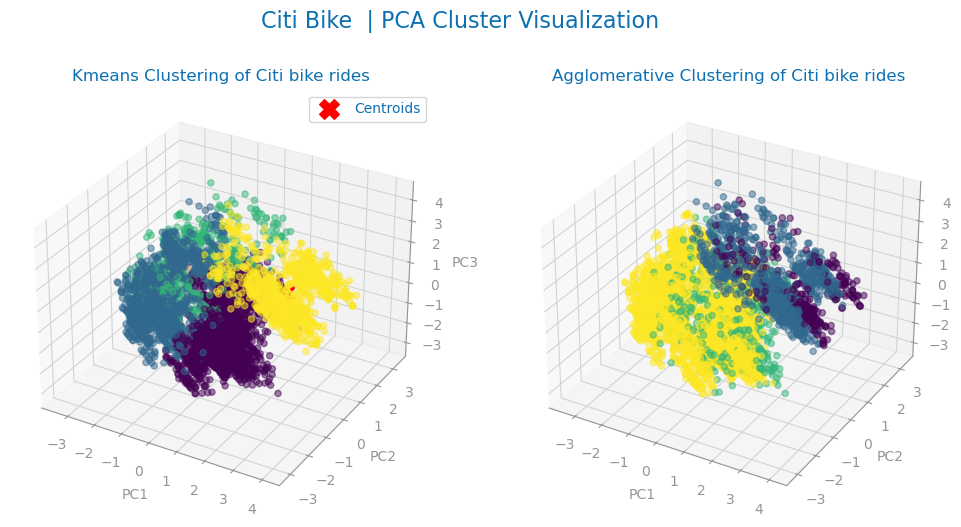

In [96]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(citibike_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Kmeans Clustering of Citi bike rides')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=citibike_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Citi bike rides')

fig.suptitle(f"{file_tag}  | PCA Cluster Visualization", fontsize=16)

plt.show()

# TO DO's 

# TO DO's 

- Data profiling
    - Check if the numeric variables of the dataset follow a normal distribuiton or not
        - check eugenia data profiling code from mod 1 notebook and copy code
Cluster Data prep
    - representar variancia das variaveis num gráfico para depois colocar no report, na parte do fetaure selection (removal redundant variables)
    - Truncate outliers e depois garantir que removemos os outliers restantes, martelando (ver como o João fez)
- Cluster application
    - Função manathan não está a correr no agglomerative clustering, corrigir a função para poder usar a distancia manathan
    - correr o agglomerative clustering com outras distancias
Descrição dos clusters
    - dendograma mexer e perceber o parametro p, para ver o impacto na quantidade de clusters 
    - Corrigir  o boxplot dos clusters labels, é isto que vai permitir descrever depois o centroide dos cluster
    - para descrever os clusters, pedir também à Eugenio o heatmap dos centroides para o kmeans
PCA
- PCA tentar melhorar a explicabilidade dos dados 


- Arranjar definição e perceber os gráficos de
    -  silueta
    -  elbow method
    - heat map 
    - boxplots 
    pcas
- Analisar os lcsuters

